# Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as func
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

!pip install torchsummary
from torchsummary import summary

import zipfile

import warnings
warnings.simplefilter("ignore")



In [3]:
torch.manual_seed(666)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Датасет

In [4]:
! kaggle datasets download -d ounimed/pizza-dataset-ready-to-use-with-yolo

with zipfile.ZipFile("pizza-dataset-ready-to-use-with-yolo.zip", 'r') as zip_ref:
  zip_ref.extractall("dataset")

Dataset URL: https://www.kaggle.com/datasets/ounimed/pizza-dataset-ready-to-use-with-yolo
License(s): unknown
 95% 95.0M/100M [00:00<00:00, 196MB/s]
100% 100M/100M [00:00<00:00, 186MB/s] 


In [5]:
class PizzaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = [cv2.cvtColor(cv2.imread(os.path.join(data_dir, image_name)), cv2.COLOR_BGR2RGB) for image_name in tqdm(os.listdir(data_dir))]
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            return self.transform(image)
        else:
            return image

    def __len__(self):
        return len(self.images)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = 'dataset/Yolo_dataset/train/images'
pizza_dataset = PizzaDataset(data_dir, transform=transform)
pizza_loader = DataLoader(pizza_dataset, batch_size=16, shuffle=True)

100%|██████████| 421/421 [00:04<00:00, 87.04it/s]


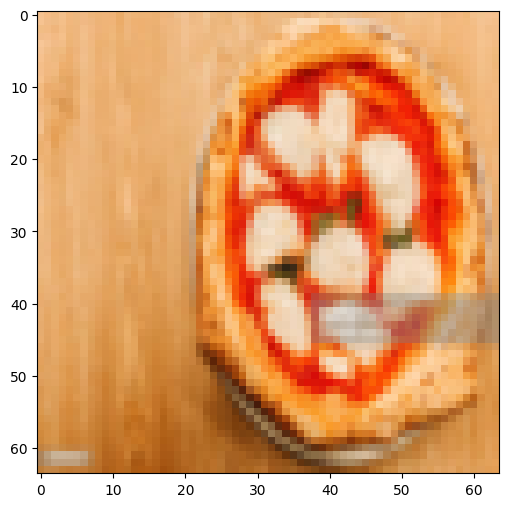

In [7]:
# посмотрим какие вообще картинки имеются в датасете
fig, ax = plt.subplots(figsize=(6,6))
test_img = next(iter(pizza_loader))[0].numpy()
test_img = (test_img - test_img.min()) / (test_img.max() - test_img.min())
ax.imshow(test_img.transpose(1,2,0))
plt.show()

# Модели

# 1. WGAN

In [8]:
class Generator(nn.Module):
    def __init__(self, nz, hidden_dim=32, out_channels=3):
        super().__init__()

        self.gen = nn.Sequential(

            nn.ConvTranspose2d(in_channels=nz, out_channels=hidden_dim*16, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(num_features=hidden_dim*16),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=hidden_dim*16, out_channels=hidden_dim*8, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=hidden_dim*8),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=hidden_dim*8, out_channels=hidden_dim*4, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=hidden_dim*4),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(num_features=hidden_dim*2),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels=hidden_dim*2, out_channels=out_channels, kernel_size=2)
            )

        self.output = nn.Tanh()

    def forward(self, x):
        x = self.gen(x)
        return self.output(x)


# проверим размерности
test_model = Generator(64)
test_model.to(device)
summary(test_model, (64, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 7, 7]       1,606,144
       BatchNorm2d-2            [-1, 512, 7, 7]           1,024
         LeakyReLU-3            [-1, 512, 7, 7]               0
   ConvTranspose2d-4          [-1, 256, 15, 15]       1,179,904
       BatchNorm2d-5          [-1, 256, 15, 15]             512
         LeakyReLU-6          [-1, 256, 15, 15]               0
   ConvTranspose2d-7          [-1, 128, 31, 31]         295,040
       BatchNorm2d-8          [-1, 128, 31, 31]             256
         LeakyReLU-9          [-1, 128, 31, 31]               0
  ConvTranspose2d-10           [-1, 64, 63, 63]          73,792
      BatchNorm2d-11           [-1, 64, 63, 63]             128
        LeakyReLU-12           [-1, 64, 63, 63]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]             771
             Tanh-14            [-1, 3,

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=3, hidden_dim=32, output_channel=1):
        super().__init__()
        self.input_channels = input_channels

        self.disc = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_dim * 2, kernel_size=5, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=hidden_dim * 2, out_channels=hidden_dim * 4, kernel_size=5, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=hidden_dim * 4, out_channels=hidden_dim * 8, kernel_size=5,stride=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=hidden_dim * 8, out_channels=hidden_dim * 16, kernel_size=5),
        )


        self.classifier = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Linear(in_features=hidden_dim*16, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=output_channel)
        )


    def forward(self, x):
        x = self.disc(x)
        x = self.classifier(x)
        return x


# проверим размерности
test_model = Discriminator()
test_model.to(device)
summary(test_model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           4,864
         LeakyReLU-2           [-1, 64, 30, 30]               0
           Dropout-3           [-1, 64, 30, 30]               0
            Conv2d-4          [-1, 128, 13, 13]         204,928
         LeakyReLU-5          [-1, 128, 13, 13]               0
           Dropout-6          [-1, 128, 13, 13]               0
            Conv2d-7            [-1, 256, 5, 5]         819,456
         LeakyReLU-8            [-1, 256, 5, 5]               0
           Dropout-9            [-1, 256, 5, 5]               0
           Conv2d-10            [-1, 512, 1, 1]       3,277,312
          Flatten-11                  [-1, 512]               0
           Linear-12                  [-1, 100]          51,300
             ReLU-13                  [-1, 100]               0
           Linear-14                   

# Функции обучения

Реализуйте обучение GAN. Какие должны быть значения у векторов $y_{true}$ и $y_{fake}$?

#### Вспомогательные функции и классы

In [10]:
'''_train_generator и _train_discriminator, _count_scores, train_gan, WassersteinLoss'''
'''---------------------------------------------------------------------------------------------------------------'''
def _train_generator(batch, gen, disc, nz, gen_loss, gen_opt, device):
    gen_opt.zero_grad() # обнуление градиента

    noise = torch.randn(batch.shape[0], nz, 1, 1, device=device) # вектор шума
    fake_img = gen(noise) # генерация картинки
    fake_preds = disc(fake_img) # предсказание дискриминатора
    targets = torch.ones(batch.shape[0], 1, device=device) # единичный вектор

    g_loss = gen_loss(fake_preds, targets) # вычисление значения функции потерь
    g_loss.backward()
    gen_opt.step()

    return g_loss

'''---------------------------------------------------------------------------------------------------------------'''
def _train_discriminator(batch, gen, disc, nz, disc_loss, disc_opt, device, gan_type='WGAN'):
    #training discriminator
    disc_opt.zero_grad() # обнуление градиентов

    real_preds = disc(batch) # предсказание дискриминатора
    real_targets = torch.ones(batch.shape[0], 1, device=device)# единичный вектор (истина)
    real_loss = disc_loss(real_preds, real_targets) # вычисление значения функции потерь между "истиной" и предсказаниями

    #generate fake images
    noise = torch.randn(batch.shape[0], nz, 1, 1, device=device) # вектор шума
    fake_img = gen(noise) # генерация картинки

    fake_preds = disc(fake_img.detach()) # предсказание дискриминатора
    fake_targets = -torch.ones(batch.shape[0], 1, device=device) # минус единичный вектор (ложь)
    fake_loss = disc_loss(fake_preds, fake_targets) # вычисление значения функции потерь между "ложью" и предсказаниями
    if gan_type == 'WGAN':
        d_loss = real_loss + fake_loss
        d_loss.backward()
        disc_opt.step()
        # ограничение параметров весов
        for param in disc.parameters():
            param.data.clamp_(-0.01, 0.01)

    elif gan_type == 'WGAN-GP':
       d_loss = real_loss + fake_loss + calculate_gradient_penalty(disc, batch, fake_img.detach(), device=device)
       d_loss.backward()
       disc_opt.step()

    return real_loss, fake_loss, d_loss




'''---------------------------------------------------------------------------------------------------------------'''
def _count_scores(real_loss, fake_loss):
    real_score = real_loss.mean().item()
    fake_score = fake_loss.mean().item()
    return real_score, fake_score


'''---------------------------------------------------------------------------------------------------------------'''
def train_gan(gen, gen_loss, gen_opt,
              disc, disc_loss, disc_opt,
              dataloader, device='cpu', epochs=1, nz=32, gan_type='WGAN'):
    print(device)
    device = torch.device(device)

    gen.train()
    disc.train()

    gen_loss.to(device)
    disc_loss.to(device)

    gen.to(device)
    disc.to(device)

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):

        losses_d_running = []
        losses_g_running = []
        real_scores_running = []
        fake_scores_running = []

        for index, batch in enumerate(tqdm(dataloader)):
            input_ = batch

            input_ = input_.to(device)
            # учим дискриминатор
            real_loss, fake_loss, d_loss = _train_discriminator(
                input_,
                gen=gen,
                disc=disc,
                nz=nz,
                disc_loss=disc_loss,
                disc_opt=disc_opt,
                device=device,
                gan_type=gan_type
            )

            losses_d_running.append(d_loss.item())

            real_score, fake_score = _count_scores(real_loss, fake_loss)


            real_scores_running.append(real_score)
            fake_scores_running.append(fake_score)

            if index % 4 == 0:
                # раз в несколько итераций учим генератор
                g_loss = _train_generator(
                    input_,
                    gen=gen,
                    disc=disc,
                    nz=nz,
                    gen_loss=gen_loss,
                    gen_opt=gen_opt,
                    device=device,
                )

                losses_g_running.append(g_loss.item())

        losses_g.append(np.mean(losses_g_running))
        losses_d.append(np.mean(losses_d_running))
        real_scores.append(np.mean(real_scores_running))
        fake_scores.append(np.mean(fake_scores_running))
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1])
        )
    return losses_g, losses_d, real_scores, fake_scores

'''---------------------------------------------------------------------------------------------------------------'''
class WassersteinLoss(nn.Module):
    def __init__(self):
        super(WassersteinLoss, self).__init__()

    def forward(self, y_true, y_pred):
        return -torch.mean(y_true * y_pred)

#### Непосредственно обучение

In [11]:
'''Объявление необходимых переменных, создание генератора и дескриминатора, loss-функции и оптимизатора'''
latent_size = 64
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

gen = Generator(latent_size).to(device)
disc = Discriminator().to(device)

disc_optim = torch.optim.RMSprop(disc.parameters(), lr=1e-5)
gen_optim = torch.optim.RMSprop(gen.parameters(), lr=1e-4)
# disc_optim = torch.optim.Adam(disc.parameters(), lr=1*10e-4)
# gen_optim = torch.optim.Adam(gen.parameters(), lr=1*10e-4)

gen_loss = WassersteinLoss()
disc_loss = WassersteinLoss()

'''Обучение'''
g_loss, d_loss, real_score, fake_score = train_gan(
    gen, gen_loss, gen_optim,
    disc, disc_loss, disc_optim,
    pizza_loader, device, epochs=epochs, nz=latent_size, gan_type='WGAN')

cpu


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch [1/1000], loss_g: -0.0095, loss_d: -0.0003, real_score: -0.0122, fake_score: 0.0118


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [2/1000], loss_g: -0.0094, loss_d: -0.0001, real_score: -0.0095, fake_score: 0.0094


100%|██████████| 27/27 [00:03<00:00,  8.01it/s]


Epoch [3/1000], loss_g: -0.0093, loss_d: -0.0001, real_score: -0.0095, fake_score: 0.0094


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [4/1000], loss_g: -0.0091, loss_d: -0.0002, real_score: -0.0094, fake_score: 0.0091


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [5/1000], loss_g: -0.0083, loss_d: -0.0007, real_score: -0.0092, fake_score: 0.0085


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [6/1000], loss_g: -0.0056, loss_d: -0.0025, real_score: -0.0085, fake_score: 0.0060


100%|██████████| 27/27 [00:03<00:00,  7.96it/s]


Epoch [7/1000], loss_g: 0.0007, loss_d: -0.0085, real_score: -0.0089, fake_score: 0.0005


100%|██████████| 27/27 [00:03<00:00,  8.28it/s]


Epoch [8/1000], loss_g: 0.0237, loss_d: -0.0278, real_score: -0.0091, fake_score: -0.0187


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [9/1000], loss_g: 0.0385, loss_d: -0.0262, real_score: 0.0009, fake_score: -0.0271


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [10/1000], loss_g: 0.0094, loss_d: 0.0038, real_score: 0.0055, fake_score: -0.0017


100%|██████████| 27/27 [00:03<00:00,  7.77it/s]


Epoch [11/1000], loss_g: -0.0184, loss_d: 0.0027, real_score: -0.0165, fake_score: 0.0192


100%|██████████| 27/27 [00:03<00:00,  8.40it/s]


Epoch [12/1000], loss_g: -0.0219, loss_d: 0.0006, real_score: -0.0214, fake_score: 0.0220


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [13/1000], loss_g: -0.0201, loss_d: 0.0005, real_score: -0.0197, fake_score: 0.0202


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [14/1000], loss_g: -0.0180, loss_d: -0.0002, real_score: -0.0183, fake_score: 0.0181


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [15/1000], loss_g: -0.0157, loss_d: -0.0011, real_score: -0.0166, fake_score: 0.0156


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [16/1000], loss_g: -0.0133, loss_d: -0.0022, real_score: -0.0154, fake_score: 0.0132


100%|██████████| 27/27 [00:03<00:00,  8.95it/s]


Epoch [17/1000], loss_g: -0.0116, loss_d: -0.0029, real_score: -0.0146, fake_score: 0.0117


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [18/1000], loss_g: -0.0133, loss_d: -0.0030, real_score: -0.0166, fake_score: 0.0137


100%|██████████| 27/27 [00:02<00:00,  9.04it/s]


Epoch [19/1000], loss_g: -0.0220, loss_d: -0.0016, real_score: -0.0250, fake_score: 0.0235


100%|██████████| 27/27 [00:03<00:00,  8.88it/s]


Epoch [20/1000], loss_g: -0.0252, loss_d: -0.0036, real_score: -0.0301, fake_score: 0.0265


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [21/1000], loss_g: -0.0225, loss_d: -0.0062, real_score: -0.0302, fake_score: 0.0239


100%|██████████| 27/27 [00:03<00:00,  7.66it/s]


Epoch [22/1000], loss_g: -0.0143, loss_d: -0.0058, real_score: -0.0220, fake_score: 0.0163


100%|██████████| 27/27 [00:03<00:00,  8.14it/s]


Epoch [23/1000], loss_g: -0.0191, loss_d: -0.0067, real_score: -0.0258, fake_score: 0.0191


100%|██████████| 27/27 [00:03<00:00,  7.97it/s]


Epoch [24/1000], loss_g: -0.0360, loss_d: -0.0066, real_score: -0.0392, fake_score: 0.0326


100%|██████████| 27/27 [00:03<00:00,  8.09it/s]


Epoch [25/1000], loss_g: -0.0228, loss_d: -0.0097, real_score: -0.0352, fake_score: 0.0255


100%|██████████| 27/27 [00:03<00:00,  7.81it/s]


Epoch [26/1000], loss_g: -0.0381, loss_d: -0.0062, real_score: -0.0441, fake_score: 0.0379


100%|██████████| 27/27 [00:03<00:00,  8.13it/s]


Epoch [27/1000], loss_g: -0.0258, loss_d: -0.0073, real_score: -0.0371, fake_score: 0.0298


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [28/1000], loss_g: -0.0340, loss_d: -0.0040, real_score: -0.0421, fake_score: 0.0381


100%|██████████| 27/27 [00:03<00:00,  8.07it/s]


Epoch [29/1000], loss_g: -0.0367, loss_d: -0.0048, real_score: -0.0457, fake_score: 0.0409


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [30/1000], loss_g: -0.0265, loss_d: -0.0078, real_score: -0.0362, fake_score: 0.0285


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [31/1000], loss_g: -0.0170, loss_d: -0.0119, real_score: -0.0361, fake_score: 0.0242


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [32/1000], loss_g: -0.0529, loss_d: 0.0009, real_score: -0.0565, fake_score: 0.0574


100%|██████████| 27/27 [00:03<00:00,  7.71it/s]


Epoch [33/1000], loss_g: -0.0477, loss_d: 0.0029, real_score: -0.0477, fake_score: 0.0506


100%|██████████| 27/27 [00:03<00:00,  8.43it/s]


Epoch [34/1000], loss_g: -0.0305, loss_d: 0.0000, real_score: -0.0338, fake_score: 0.0338


100%|██████████| 27/27 [00:03<00:00,  8.18it/s]


Epoch [35/1000], loss_g: -0.0236, loss_d: -0.0026, real_score: -0.0273, fake_score: 0.0247


100%|██████████| 27/27 [00:03<00:00,  8.15it/s]


Epoch [36/1000], loss_g: -0.0363, loss_d: -0.0037, real_score: -0.0415, fake_score: 0.0378


100%|██████████| 27/27 [00:03<00:00,  7.95it/s]


Epoch [37/1000], loss_g: -0.0363, loss_d: -0.0054, real_score: -0.0415, fake_score: 0.0361


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [38/1000], loss_g: -0.0360, loss_d: -0.0057, real_score: -0.0435, fake_score: 0.0378


100%|██████████| 27/27 [00:03<00:00,  8.47it/s]


Epoch [39/1000], loss_g: -0.0237, loss_d: -0.0109, real_score: -0.0369, fake_score: 0.0260


100%|██████████| 27/27 [00:03<00:00,  7.90it/s]


Epoch [40/1000], loss_g: -0.0259, loss_d: -0.0087, real_score: -0.0360, fake_score: 0.0273


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [41/1000], loss_g: -0.0292, loss_d: -0.0076, real_score: -0.0397, fake_score: 0.0321


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [42/1000], loss_g: -0.0346, loss_d: -0.0062, real_score: -0.0445, fake_score: 0.0383


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [43/1000], loss_g: -0.0383, loss_d: -0.0027, real_score: -0.0457, fake_score: 0.0430


100%|██████████| 27/27 [00:03<00:00,  7.70it/s]


Epoch [44/1000], loss_g: -0.0260, loss_d: -0.0001, real_score: -0.0293, fake_score: 0.0292


100%|██████████| 27/27 [00:03<00:00,  8.34it/s]


Epoch [45/1000], loss_g: -0.0148, loss_d: -0.0051, real_score: -0.0229, fake_score: 0.0178


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [46/1000], loss_g: -0.0191, loss_d: -0.0057, real_score: -0.0265, fake_score: 0.0208


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [47/1000], loss_g: -0.0034, loss_d: -0.0128, real_score: -0.0205, fake_score: 0.0077


100%|██████████| 27/27 [00:03<00:00,  8.00it/s]


Epoch [48/1000], loss_g: -0.0287, loss_d: -0.0058, real_score: -0.0405, fake_score: 0.0347


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [49/1000], loss_g: -0.0376, loss_d: -0.0036, real_score: -0.0444, fake_score: 0.0409


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [50/1000], loss_g: -0.0362, loss_d: -0.0034, real_score: -0.0437, fake_score: 0.0404


100%|██████████| 27/27 [00:03<00:00,  8.35it/s]


Epoch [51/1000], loss_g: -0.0348, loss_d: -0.0018, real_score: -0.0420, fake_score: 0.0402


100%|██████████| 27/27 [00:03<00:00,  7.89it/s]


Epoch [52/1000], loss_g: -0.0324, loss_d: 0.0000, real_score: -0.0368, fake_score: 0.0368


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [53/1000], loss_g: -0.0251, loss_d: -0.0051, real_score: -0.0351, fake_score: 0.0300


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [54/1000], loss_g: -0.0287, loss_d: -0.0061, real_score: -0.0368, fake_score: 0.0306


100%|██████████| 27/27 [00:03<00:00,  8.29it/s]


Epoch [55/1000], loss_g: -0.0233, loss_d: -0.0061, real_score: -0.0320, fake_score: 0.0259


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [56/1000], loss_g: -0.0150, loss_d: -0.0079, real_score: -0.0240, fake_score: 0.0162


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [57/1000], loss_g: -0.0100, loss_d: -0.0085, real_score: -0.0240, fake_score: 0.0155


100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


Epoch [58/1000], loss_g: -0.0174, loss_d: -0.0040, real_score: -0.0260, fake_score: 0.0220


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [59/1000], loss_g: -0.0020, loss_d: -0.0076, real_score: -0.0143, fake_score: 0.0067


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [60/1000], loss_g: -0.0264, loss_d: -0.0052, real_score: -0.0372, fake_score: 0.0320


100%|██████████| 27/27 [00:03<00:00,  7.88it/s]


Epoch [61/1000], loss_g: -0.0285, loss_d: -0.0022, real_score: -0.0360, fake_score: 0.0338


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [62/1000], loss_g: -0.0236, loss_d: -0.0050, real_score: -0.0321, fake_score: 0.0271


100%|██████████| 27/27 [00:03<00:00,  8.04it/s]


Epoch [63/1000], loss_g: -0.0207, loss_d: -0.0065, real_score: -0.0349, fake_score: 0.0284


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [64/1000], loss_g: -0.0170, loss_d: -0.0101, real_score: -0.0297, fake_score: 0.0196


100%|██████████| 27/27 [00:03<00:00,  8.93it/s]


Epoch [65/1000], loss_g: 0.0095, loss_d: -0.0062, real_score: -0.0029, fake_score: -0.0033


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [66/1000], loss_g: -0.0401, loss_d: -0.0084, real_score: -0.0509, fake_score: 0.0425


100%|██████████| 27/27 [00:03<00:00,  7.93it/s]


Epoch [67/1000], loss_g: -0.0121, loss_d: -0.0079, real_score: -0.0242, fake_score: 0.0163


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [68/1000], loss_g: -0.0225, loss_d: -0.0054, real_score: -0.0327, fake_score: 0.0273


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [69/1000], loss_g: 0.0064, loss_d: -0.0059, real_score: -0.0041, fake_score: -0.0019


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [70/1000], loss_g: -0.0084, loss_d: -0.0013, real_score: -0.0171, fake_score: 0.0158


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [71/1000], loss_g: -0.0196, loss_d: -0.0008, real_score: -0.0260, fake_score: 0.0252


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [72/1000], loss_g: 0.0086, loss_d: -0.0058, real_score: 0.0023, fake_score: -0.0081


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [73/1000], loss_g: -0.0094, loss_d: -0.0040, real_score: -0.0166, fake_score: 0.0126


100%|██████████| 27/27 [00:03<00:00,  8.42it/s]


Epoch [74/1000], loss_g: 0.0044, loss_d: -0.0081, real_score: -0.0088, fake_score: 0.0007


100%|██████████| 27/27 [00:03<00:00,  8.48it/s]


Epoch [75/1000], loss_g: -0.0099, loss_d: -0.0075, real_score: -0.0212, fake_score: 0.0137


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [76/1000], loss_g: -0.0031, loss_d: -0.0061, real_score: -0.0155, fake_score: 0.0094


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [77/1000], loss_g: 0.0244, loss_d: -0.0095, real_score: 0.0025, fake_score: -0.0119


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [78/1000], loss_g: 0.0132, loss_d: -0.0113, real_score: -0.0077, fake_score: -0.0035


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [79/1000], loss_g: 0.0212, loss_d: -0.0101, real_score: 0.0007, fake_score: -0.0108


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [80/1000], loss_g: 0.0188, loss_d: -0.0077, real_score: 0.0050, fake_score: -0.0127


100%|██████████| 27/27 [00:03<00:00,  8.56it/s]


Epoch [81/1000], loss_g: 0.0279, loss_d: -0.0124, real_score: 0.0091, fake_score: -0.0214


100%|██████████| 27/27 [00:03<00:00,  8.10it/s]


Epoch [82/1000], loss_g: -0.0043, loss_d: -0.0064, real_score: -0.0117, fake_score: 0.0053


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [83/1000], loss_g: 0.0246, loss_d: -0.0067, real_score: 0.0104, fake_score: -0.0172


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [84/1000], loss_g: 0.0058, loss_d: -0.0060, real_score: -0.0053, fake_score: -0.0007


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [85/1000], loss_g: -0.0152, loss_d: -0.0099, real_score: -0.0276, fake_score: 0.0177


100%|██████████| 27/27 [00:03<00:00,  7.53it/s]


Epoch [86/1000], loss_g: 0.0498, loss_d: -0.0087, real_score: 0.0355, fake_score: -0.0442


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [87/1000], loss_g: 0.0001, loss_d: -0.0077, real_score: -0.0145, fake_score: 0.0068


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [88/1000], loss_g: 0.0435, loss_d: -0.0092, real_score: 0.0247, fake_score: -0.0339


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [89/1000], loss_g: 0.0253, loss_d: -0.0100, real_score: 0.0094, fake_score: -0.0194


100%|██████████| 27/27 [00:03<00:00,  7.99it/s]


Epoch [90/1000], loss_g: 0.0087, loss_d: -0.0102, real_score: -0.0075, fake_score: -0.0027


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [91/1000], loss_g: 0.0223, loss_d: -0.0091, real_score: 0.0051, fake_score: -0.0142


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [92/1000], loss_g: 0.0170, loss_d: -0.0075, real_score: 0.0049, fake_score: -0.0124


100%|██████████| 27/27 [00:03<00:00,  8.18it/s]


Epoch [93/1000], loss_g: 0.0189, loss_d: -0.0070, real_score: 0.0173, fake_score: -0.0243


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [94/1000], loss_g: 0.0092, loss_d: -0.0064, real_score: -0.0041, fake_score: -0.0023


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [95/1000], loss_g: 0.0170, loss_d: -0.0075, real_score: -0.0009, fake_score: -0.0066


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [96/1000], loss_g: 0.0260, loss_d: -0.0088, real_score: 0.0065, fake_score: -0.0154


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [97/1000], loss_g: 0.0055, loss_d: -0.0098, real_score: -0.0078, fake_score: -0.0020


100%|██████████| 27/27 [00:03<00:00,  8.29it/s]


Epoch [98/1000], loss_g: 0.0321, loss_d: -0.0079, real_score: 0.0120, fake_score: -0.0199


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [99/1000], loss_g: -0.0126, loss_d: -0.0065, real_score: -0.0269, fake_score: 0.0205


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [100/1000], loss_g: 0.0313, loss_d: -0.0069, real_score: 0.0189, fake_score: -0.0257


100%|██████████| 27/27 [00:03<00:00,  8.43it/s]


Epoch [101/1000], loss_g: -0.0228, loss_d: -0.0073, real_score: -0.0362, fake_score: 0.0289


100%|██████████| 27/27 [00:03<00:00,  8.33it/s]


Epoch [102/1000], loss_g: 0.0260, loss_d: -0.0112, real_score: 0.0038, fake_score: -0.0150


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [103/1000], loss_g: 0.0182, loss_d: -0.0092, real_score: -0.0091, fake_score: -0.0001


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [104/1000], loss_g: 0.0198, loss_d: -0.0087, real_score: 0.0045, fake_score: -0.0133


100%|██████████| 27/27 [00:03<00:00,  8.11it/s]


Epoch [105/1000], loss_g: 0.0202, loss_d: -0.0070, real_score: 0.0124, fake_score: -0.0195


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [106/1000], loss_g: 0.0293, loss_d: -0.0051, real_score: 0.0189, fake_score: -0.0240


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [107/1000], loss_g: 0.0346, loss_d: -0.0136, real_score: 0.0067, fake_score: -0.0203


100%|██████████| 27/27 [00:03<00:00,  8.57it/s]


Epoch [108/1000], loss_g: 0.0266, loss_d: -0.0085, real_score: 0.0116, fake_score: -0.0201


100%|██████████| 27/27 [00:03<00:00,  8.13it/s]


Epoch [109/1000], loss_g: 0.0226, loss_d: -0.0114, real_score: 0.0022, fake_score: -0.0136


100%|██████████| 27/27 [00:03<00:00,  8.86it/s]


Epoch [110/1000], loss_g: 0.0588, loss_d: -0.0132, real_score: 0.0332, fake_score: -0.0464


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [111/1000], loss_g: 0.0362, loss_d: -0.0100, real_score: 0.0151, fake_score: -0.0251


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [112/1000], loss_g: 0.0221, loss_d: -0.0062, real_score: 0.0062, fake_score: -0.0124


100%|██████████| 27/27 [00:03<00:00,  8.19it/s]


Epoch [113/1000], loss_g: 0.0214, loss_d: -0.0030, real_score: -0.0008, fake_score: -0.0022


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [114/1000], loss_g: 0.0041, loss_d: -0.0023, real_score: -0.0001, fake_score: -0.0022


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [115/1000], loss_g: 0.0607, loss_d: -0.0016, real_score: 0.0525, fake_score: -0.0541


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [116/1000], loss_g: -0.0109, loss_d: -0.0073, real_score: -0.0261, fake_score: 0.0188


100%|██████████| 27/27 [00:03<00:00,  8.41it/s]


Epoch [117/1000], loss_g: 0.0138, loss_d: -0.0033, real_score: 0.0051, fake_score: -0.0084


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [118/1000], loss_g: 0.0679, loss_d: -0.0109, real_score: 0.0488, fake_score: -0.0597


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [119/1000], loss_g: 0.0183, loss_d: -0.0094, real_score: 0.0096, fake_score: -0.0189


100%|██████████| 27/27 [00:03<00:00,  8.34it/s]


Epoch [120/1000], loss_g: -0.0030, loss_d: -0.0061, real_score: -0.0152, fake_score: 0.0091


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [121/1000], loss_g: 0.0499, loss_d: -0.0083, real_score: 0.0359, fake_score: -0.0443


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [122/1000], loss_g: 0.0566, loss_d: -0.0094, real_score: 0.0362, fake_score: -0.0456


100%|██████████| 27/27 [00:03<00:00,  8.88it/s]


Epoch [123/1000], loss_g: -0.0087, loss_d: -0.0097, real_score: -0.0286, fake_score: 0.0189


100%|██████████| 27/27 [00:03<00:00,  8.21it/s]


Epoch [124/1000], loss_g: 0.0170, loss_d: 0.0016, real_score: 0.0132, fake_score: -0.0116


100%|██████████| 27/27 [00:03<00:00,  8.41it/s]


Epoch [125/1000], loss_g: 0.0657, loss_d: -0.0092, real_score: 0.0431, fake_score: -0.0524


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [126/1000], loss_g: 0.0541, loss_d: -0.0071, real_score: 0.0297, fake_score: -0.0368


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [127/1000], loss_g: -0.0058, loss_d: -0.0033, real_score: -0.0192, fake_score: 0.0159


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [128/1000], loss_g: 0.0877, loss_d: -0.0072, real_score: 0.0734, fake_score: -0.0806


100%|██████████| 27/27 [00:03<00:00,  8.79it/s]


Epoch [129/1000], loss_g: 0.0208, loss_d: -0.0039, real_score: 0.0025, fake_score: -0.0064


100%|██████████| 27/27 [00:03<00:00,  8.79it/s]


Epoch [130/1000], loss_g: 0.0468, loss_d: -0.0091, real_score: 0.0291, fake_score: -0.0382


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [131/1000], loss_g: 0.0391, loss_d: -0.0102, real_score: 0.0257, fake_score: -0.0358


100%|██████████| 27/27 [00:03<00:00,  7.79it/s]


Epoch [132/1000], loss_g: 0.1055, loss_d: 0.0005, real_score: 0.1055, fake_score: -0.1050


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [133/1000], loss_g: 0.0232, loss_d: -0.0127, real_score: 0.0035, fake_score: -0.0162


100%|██████████| 27/27 [00:03<00:00,  8.33it/s]


Epoch [134/1000], loss_g: 0.0544, loss_d: -0.0150, real_score: 0.0171, fake_score: -0.0321


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [135/1000], loss_g: 0.1041, loss_d: -0.0077, real_score: 0.0892, fake_score: -0.0969


100%|██████████| 27/27 [00:03<00:00,  8.09it/s]


Epoch [136/1000], loss_g: 0.0899, loss_d: -0.0080, real_score: 0.0775, fake_score: -0.0856


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [137/1000], loss_g: 0.0049, loss_d: -0.0056, real_score: -0.0092, fake_score: 0.0036


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [138/1000], loss_g: 0.1137, loss_d: -0.0049, real_score: 0.0980, fake_score: -0.1030


100%|██████████| 27/27 [00:03<00:00,  8.34it/s]


Epoch [139/1000], loss_g: 0.0575, loss_d: -0.0063, real_score: 0.0446, fake_score: -0.0509


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [140/1000], loss_g: 0.0823, loss_d: -0.0092, real_score: 0.0640, fake_score: -0.0731


100%|██████████| 27/27 [00:03<00:00,  8.93it/s]


Epoch [141/1000], loss_g: 0.1037, loss_d: -0.0017, real_score: 0.0920, fake_score: -0.0938


100%|██████████| 27/27 [00:02<00:00,  9.15it/s]


Epoch [142/1000], loss_g: 0.0286, loss_d: -0.0079, real_score: 0.0178, fake_score: -0.0256


100%|██████████| 27/27 [00:03<00:00,  8.41it/s]


Epoch [143/1000], loss_g: 0.1194, loss_d: -0.0110, real_score: 0.1038, fake_score: -0.1148


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [144/1000], loss_g: -0.0337, loss_d: -0.0089, real_score: -0.0549, fake_score: 0.0460


100%|██████████| 27/27 [00:03<00:00,  9.00it/s]


Epoch [145/1000], loss_g: -0.0571, loss_d: 0.0082, real_score: -0.0527, fake_score: 0.0609


100%|██████████| 27/27 [00:02<00:00,  9.24it/s]


Epoch [146/1000], loss_g: 0.2085, loss_d: 0.0020, real_score: 0.2011, fake_score: -0.1991


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [147/1000], loss_g: -0.1214, loss_d: -0.0014, real_score: -0.1271, fake_score: 0.1257


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [148/1000], loss_g: -0.0074, loss_d: -0.0094, real_score: -0.0324, fake_score: 0.0231


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [149/1000], loss_g: 0.0971, loss_d: -0.0056, real_score: 0.0707, fake_score: -0.0764


100%|██████████| 27/27 [00:02<00:00,  9.14it/s]


Epoch [150/1000], loss_g: 0.0284, loss_d: -0.0061, real_score: 0.0086, fake_score: -0.0147


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [151/1000], loss_g: -0.0965, loss_d: -0.0008, real_score: -0.1036, fake_score: 0.1028


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [152/1000], loss_g: -0.0184, loss_d: -0.0096, real_score: -0.0231, fake_score: 0.0135


100%|██████████| 27/27 [00:02<00:00,  9.20it/s]


Epoch [153/1000], loss_g: 0.0914, loss_d: -0.0102, real_score: 0.0599, fake_score: -0.0701


100%|██████████| 27/27 [00:02<00:00,  9.06it/s]


Epoch [154/1000], loss_g: 0.0420, loss_d: -0.0090, real_score: 0.0188, fake_score: -0.0278


100%|██████████| 27/27 [00:03<00:00,  7.97it/s]


Epoch [155/1000], loss_g: 0.0260, loss_d: -0.0084, real_score: 0.0042, fake_score: -0.0127


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [156/1000], loss_g: 0.0659, loss_d: -0.0160, real_score: 0.0463, fake_score: -0.0623


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [157/1000], loss_g: 0.0371, loss_d: -0.0109, real_score: 0.0152, fake_score: -0.0260


100%|██████████| 27/27 [00:03<00:00,  8.35it/s]


Epoch [158/1000], loss_g: 0.0687, loss_d: -0.0053, real_score: 0.0547, fake_score: -0.0600


100%|██████████| 27/27 [00:03<00:00,  7.77it/s]


Epoch [159/1000], loss_g: 0.0340, loss_d: -0.0146, real_score: 0.0079, fake_score: -0.0226


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [160/1000], loss_g: 0.0866, loss_d: -0.0216, real_score: 0.0584, fake_score: -0.0800


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [161/1000], loss_g: 0.0847, loss_d: -0.0148, real_score: 0.0596, fake_score: -0.0744


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [162/1000], loss_g: 0.0196, loss_d: 0.0032, real_score: 0.0068, fake_score: -0.0036


100%|██████████| 27/27 [00:03<00:00,  7.83it/s]


Epoch [163/1000], loss_g: 0.0590, loss_d: 0.0013, real_score: 0.0582, fake_score: -0.0569


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [164/1000], loss_g: 0.0668, loss_d: -0.0088, real_score: 0.0463, fake_score: -0.0551


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [165/1000], loss_g: 0.0832, loss_d: -0.0122, real_score: 0.0657, fake_score: -0.0779


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [166/1000], loss_g: 0.0781, loss_d: -0.0161, real_score: 0.0674, fake_score: -0.0835


100%|██████████| 27/27 [00:03<00:00,  8.13it/s]


Epoch [167/1000], loss_g: 0.0643, loss_d: -0.0184, real_score: 0.0427, fake_score: -0.0612


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [168/1000], loss_g: 0.0826, loss_d: -0.0178, real_score: 0.0523, fake_score: -0.0701


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [169/1000], loss_g: 0.0988, loss_d: -0.0139, real_score: 0.0620, fake_score: -0.0758


100%|██████████| 27/27 [00:03<00:00,  8.15it/s]


Epoch [170/1000], loss_g: -0.1276, loss_d: 0.0079, real_score: -0.1214, fake_score: 0.1293


100%|██████████| 27/27 [00:03<00:00,  8.34it/s]


Epoch [171/1000], loss_g: 0.1742, loss_d: 0.0017, real_score: 0.1599, fake_score: -0.1582


100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


Epoch [172/1000], loss_g: 0.0451, loss_d: -0.0180, real_score: 0.0071, fake_score: -0.0251


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [173/1000], loss_g: 0.0493, loss_d: -0.0118, real_score: 0.0176, fake_score: -0.0294


100%|██████████| 27/27 [00:03<00:00,  8.26it/s]


Epoch [174/1000], loss_g: 0.0589, loss_d: -0.0072, real_score: 0.0341, fake_score: -0.0413


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [175/1000], loss_g: 0.0477, loss_d: -0.0078, real_score: 0.0317, fake_score: -0.0395


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [176/1000], loss_g: 0.0895, loss_d: -0.0062, real_score: 0.0763, fake_score: -0.0826


100%|██████████| 27/27 [00:02<00:00,  9.20it/s]


Epoch [177/1000], loss_g: 0.0518, loss_d: -0.0017, real_score: 0.0330, fake_score: -0.0347


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [178/1000], loss_g: 0.0926, loss_d: -0.0154, real_score: 0.0828, fake_score: -0.0982


100%|██████████| 27/27 [00:03<00:00,  8.89it/s]


Epoch [179/1000], loss_g: -0.1183, loss_d: 0.0068, real_score: -0.1165, fake_score: 0.1233


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [180/1000], loss_g: 0.1844, loss_d: -0.0029, real_score: 0.1717, fake_score: -0.1746


100%|██████████| 27/27 [00:02<00:00,  9.08it/s]


Epoch [181/1000], loss_g: -0.0077, loss_d: 0.0005, real_score: -0.0064, fake_score: 0.0069


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [182/1000], loss_g: -0.1684, loss_d: 0.0082, real_score: -0.1592, fake_score: 0.1674


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [183/1000], loss_g: 0.1081, loss_d: 0.0007, real_score: 0.1003, fake_score: -0.0996


100%|██████████| 27/27 [00:02<00:00,  9.02it/s]


Epoch [184/1000], loss_g: 0.0283, loss_d: -0.0109, real_score: -0.0012, fake_score: -0.0098


100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


Epoch [185/1000], loss_g: 0.0480, loss_d: -0.0180, real_score: 0.0166, fake_score: -0.0346


100%|██████████| 27/27 [00:03<00:00,  7.92it/s]


Epoch [186/1000], loss_g: -0.1207, loss_d: 0.0030, real_score: -0.1238, fake_score: 0.1268


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [187/1000], loss_g: -0.1066, loss_d: 0.0065, real_score: -0.1067, fake_score: 0.1133


100%|██████████| 27/27 [00:03<00:00,  8.95it/s]


Epoch [188/1000], loss_g: 0.1897, loss_d: -0.0026, real_score: 0.1798, fake_score: -0.1824


100%|██████████| 27/27 [00:03<00:00,  8.56it/s]


Epoch [189/1000], loss_g: -0.0127, loss_d: -0.0092, real_score: -0.0258, fake_score: 0.0166


100%|██████████| 27/27 [00:03<00:00,  7.95it/s]


Epoch [190/1000], loss_g: -0.0986, loss_d: 0.0003, real_score: -0.1091, fake_score: 0.1095


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [191/1000], loss_g: 0.0812, loss_d: -0.0125, real_score: 0.0450, fake_score: -0.0575


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [192/1000], loss_g: 0.0481, loss_d: -0.0060, real_score: 0.0297, fake_score: -0.0357


100%|██████████| 27/27 [00:03<00:00,  8.15it/s]


Epoch [193/1000], loss_g: 0.0739, loss_d: -0.0121, real_score: 0.0372, fake_score: -0.0493


100%|██████████| 27/27 [00:03<00:00,  8.26it/s]


Epoch [194/1000], loss_g: 0.0425, loss_d: -0.0114, real_score: 0.0199, fake_score: -0.0313


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [195/1000], loss_g: 0.0596, loss_d: -0.0154, real_score: 0.0369, fake_score: -0.0523


100%|██████████| 27/27 [00:02<00:00,  9.38it/s]


Epoch [196/1000], loss_g: 0.1348, loss_d: -0.0031, real_score: 0.1144, fake_score: -0.1175


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [197/1000], loss_g: 0.0476, loss_d: -0.0041, real_score: 0.0389, fake_score: -0.0429


100%|██████████| 27/27 [00:03<00:00,  8.43it/s]


Epoch [198/1000], loss_g: 0.1117, loss_d: -0.0077, real_score: 0.1002, fake_score: -0.1080


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [199/1000], loss_g: 0.0893, loss_d: -0.0167, real_score: 0.0605, fake_score: -0.0772


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [200/1000], loss_g: 0.1129, loss_d: -0.0092, real_score: 0.0969, fake_score: -0.1061


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [201/1000], loss_g: 0.1196, loss_d: 0.0015, real_score: 0.1160, fake_score: -0.1145


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [202/1000], loss_g: 0.0783, loss_d: -0.0103, real_score: 0.0638, fake_score: -0.0742


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [203/1000], loss_g: 0.0994, loss_d: -0.0083, real_score: 0.0717, fake_score: -0.0800


100%|██████████| 27/27 [00:02<00:00,  9.11it/s]


Epoch [204/1000], loss_g: -0.1211, loss_d: 0.0124, real_score: -0.1162, fake_score: 0.1286


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [205/1000], loss_g: 0.1677, loss_d: -0.0034, real_score: 0.1451, fake_score: -0.1485


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [206/1000], loss_g: -0.0025, loss_d: 0.0038, real_score: -0.0048, fake_score: 0.0086


100%|██████████| 27/27 [00:02<00:00,  9.06it/s]


Epoch [207/1000], loss_g: -0.1352, loss_d: 0.0019, real_score: -0.1358, fake_score: 0.1377


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [208/1000], loss_g: -0.1054, loss_d: 0.0072, real_score: -0.1039, fake_score: 0.1111


100%|██████████| 27/27 [00:03<00:00,  8.37it/s]


Epoch [209/1000], loss_g: 0.1070, loss_d: -0.0132, real_score: 0.0945, fake_score: -0.1077


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [210/1000], loss_g: -0.0418, loss_d: -0.0060, real_score: -0.0665, fake_score: 0.0605


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [211/1000], loss_g: -0.1238, loss_d: 0.0045, real_score: -0.1238, fake_score: 0.1283


100%|██████████| 27/27 [00:02<00:00,  9.03it/s]


Epoch [212/1000], loss_g: 0.0520, loss_d: -0.0048, real_score: 0.0428, fake_score: -0.0476


100%|██████████| 27/27 [00:03<00:00,  8.31it/s]


Epoch [213/1000], loss_g: 0.0176, loss_d: -0.0180, real_score: -0.0173, fake_score: -0.0007


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [214/1000], loss_g: 0.0188, loss_d: -0.0200, real_score: -0.0048, fake_score: -0.0153


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [215/1000], loss_g: 0.0199, loss_d: -0.0117, real_score: -0.0050, fake_score: -0.0067


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [216/1000], loss_g: 0.0513, loss_d: -0.0086, real_score: 0.0354, fake_score: -0.0441


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [217/1000], loss_g: 0.0616, loss_d: -0.0120, real_score: 0.0374, fake_score: -0.0494


100%|██████████| 27/27 [00:03<00:00,  8.98it/s]


Epoch [218/1000], loss_g: 0.0446, loss_d: -0.0074, real_score: 0.0314, fake_score: -0.0388


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [219/1000], loss_g: 0.1160, loss_d: -0.0055, real_score: 0.1025, fake_score: -0.1080


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [220/1000], loss_g: 0.0435, loss_d: -0.0089, real_score: 0.0265, fake_score: -0.0354


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [221/1000], loss_g: 0.0988, loss_d: -0.0083, real_score: 0.0889, fake_score: -0.0972


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [222/1000], loss_g: 0.0264, loss_d: -0.0068, real_score: 0.0040, fake_score: -0.0108


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [223/1000], loss_g: 0.0987, loss_d: -0.0067, real_score: 0.0945, fake_score: -0.1013


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [224/1000], loss_g: 0.1119, loss_d: 0.0034, real_score: 0.1074, fake_score: -0.1041


100%|██████████| 27/27 [00:03<00:00,  8.37it/s]


Epoch [225/1000], loss_g: 0.0689, loss_d: -0.0011, real_score: 0.0562, fake_score: -0.0573


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [226/1000], loss_g: 0.1171, loss_d: -0.0109, real_score: 0.1015, fake_score: -0.1124


100%|██████████| 27/27 [00:02<00:00,  9.15it/s]


Epoch [227/1000], loss_g: 0.1399, loss_d: -0.0067, real_score: 0.1233, fake_score: -0.1300


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [228/1000], loss_g: 0.0415, loss_d: -0.0029, real_score: 0.0321, fake_score: -0.0350


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [229/1000], loss_g: 0.1222, loss_d: 0.0015, real_score: 0.1300, fake_score: -0.1285


100%|██████████| 27/27 [00:03<00:00,  8.56it/s]


Epoch [230/1000], loss_g: 0.1031, loss_d: -0.0001, real_score: 0.1026, fake_score: -0.1028


100%|██████████| 27/27 [00:03<00:00,  8.89it/s]


Epoch [231/1000], loss_g: 0.0700, loss_d: -0.0038, real_score: 0.0624, fake_score: -0.0662


100%|██████████| 27/27 [00:03<00:00,  8.28it/s]


Epoch [232/1000], loss_g: 0.1332, loss_d: 0.0032, real_score: 0.1253, fake_score: -0.1221


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [233/1000], loss_g: 0.1177, loss_d: -0.0012, real_score: 0.1119, fake_score: -0.1131


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [234/1000], loss_g: 0.1143, loss_d: -0.0056, real_score: 0.0989, fake_score: -0.1045


100%|██████████| 27/27 [00:02<00:00,  9.07it/s]


Epoch [235/1000], loss_g: 0.1401, loss_d: -0.0031, real_score: 0.1268, fake_score: -0.1300


100%|██████████| 27/27 [00:03<00:00,  7.91it/s]


Epoch [236/1000], loss_g: 0.0739, loss_d: -0.0052, real_score: 0.0588, fake_score: -0.0640


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [237/1000], loss_g: 0.1789, loss_d: 0.0046, real_score: 0.1811, fake_score: -0.1765


100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


Epoch [238/1000], loss_g: 0.0653, loss_d: -0.0039, real_score: 0.0484, fake_score: -0.0523


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [239/1000], loss_g: 0.1708, loss_d: -0.0026, real_score: 0.1608, fake_score: -0.1634


100%|██████████| 27/27 [00:03<00:00,  8.08it/s]


Epoch [240/1000], loss_g: 0.1284, loss_d: -0.0035, real_score: 0.1146, fake_score: -0.1181


100%|██████████| 27/27 [00:03<00:00,  8.28it/s]


Epoch [241/1000], loss_g: 0.1137, loss_d: -0.0002, real_score: 0.1086, fake_score: -0.1088


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [242/1000], loss_g: 0.1650, loss_d: -0.0040, real_score: 0.1592, fake_score: -0.1632


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [243/1000], loss_g: 0.0993, loss_d: -0.0048, real_score: 0.0870, fake_score: -0.0917


100%|██████████| 27/27 [00:03<00:00,  8.30it/s]


Epoch [244/1000], loss_g: 0.1872, loss_d: -0.0003, real_score: 0.1830, fake_score: -0.1833


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [245/1000], loss_g: 0.1177, loss_d: -0.0033, real_score: 0.1081, fake_score: -0.1114


100%|██████████| 27/27 [00:03<00:00,  8.88it/s]


Epoch [246/1000], loss_g: 0.1918, loss_d: -0.0043, real_score: 0.1858, fake_score: -0.1901


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [247/1000], loss_g: 0.1474, loss_d: 0.0007, real_score: 0.1396, fake_score: -0.1390


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [248/1000], loss_g: 0.1525, loss_d: -0.0029, real_score: 0.1543, fake_score: -0.1572


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [249/1000], loss_g: 0.1553, loss_d: -0.0087, real_score: 0.1299, fake_score: -0.1386


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [250/1000], loss_g: 0.1858, loss_d: -0.0064, real_score: 0.1747, fake_score: -0.1811


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [251/1000], loss_g: 0.1301, loss_d: -0.0075, real_score: 0.1155, fake_score: -0.1230


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [252/1000], loss_g: 0.2088, loss_d: 0.0004, real_score: 0.2023, fake_score: -0.2019


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [253/1000], loss_g: 0.1264, loss_d: -0.0012, real_score: 0.1199, fake_score: -0.1210


100%|██████████| 27/27 [00:03<00:00,  8.93it/s]


Epoch [254/1000], loss_g: 0.1503, loss_d: -0.0004, real_score: 0.1551, fake_score: -0.1555


100%|██████████| 27/27 [00:03<00:00,  8.04it/s]


Epoch [255/1000], loss_g: 0.1375, loss_d: -0.0023, real_score: 0.1334, fake_score: -0.1357


100%|██████████| 27/27 [00:03<00:00,  8.30it/s]


Epoch [256/1000], loss_g: 0.1712, loss_d: -0.0004, real_score: 0.1724, fake_score: -0.1728


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [257/1000], loss_g: 0.1467, loss_d: -0.0061, real_score: 0.1394, fake_score: -0.1455


100%|██████████| 27/27 [00:03<00:00,  8.95it/s]


Epoch [258/1000], loss_g: 0.1485, loss_d: -0.0033, real_score: 0.1462, fake_score: -0.1495


100%|██████████| 27/27 [00:03<00:00,  8.11it/s]


Epoch [259/1000], loss_g: 0.1578, loss_d: -0.0026, real_score: 0.1473, fake_score: -0.1499


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [260/1000], loss_g: 0.1420, loss_d: -0.0040, real_score: 0.1307, fake_score: -0.1347


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [261/1000], loss_g: 0.1675, loss_d: -0.0026, real_score: 0.1617, fake_score: -0.1642


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [262/1000], loss_g: 0.1290, loss_d: -0.0050, real_score: 0.1268, fake_score: -0.1319


100%|██████████| 27/27 [00:03<00:00,  8.08it/s]


Epoch [263/1000], loss_g: 0.1719, loss_d: -0.0020, real_score: 0.1629, fake_score: -0.1648


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [264/1000], loss_g: 0.1369, loss_d: -0.0053, real_score: 0.1261, fake_score: -0.1315


100%|██████████| 27/27 [00:02<00:00,  9.12it/s]


Epoch [265/1000], loss_g: 0.1729, loss_d: 0.0004, real_score: 0.1701, fake_score: -0.1696


100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


Epoch [266/1000], loss_g: 0.1280, loss_d: -0.0035, real_score: 0.1176, fake_score: -0.1211


100%|██████████| 27/27 [00:03<00:00,  7.90it/s]


Epoch [267/1000], loss_g: 0.1906, loss_d: -0.0018, real_score: 0.1846, fake_score: -0.1864


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [268/1000], loss_g: 0.1119, loss_d: -0.0080, real_score: 0.1021, fake_score: -0.1101


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [269/1000], loss_g: 0.2247, loss_d: -0.0031, real_score: 0.2221, fake_score: -0.2252


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [270/1000], loss_g: 0.1078, loss_d: -0.0018, real_score: 0.0946, fake_score: -0.0964


100%|██████████| 27/27 [00:03<00:00,  8.34it/s]


Epoch [271/1000], loss_g: 0.1376, loss_d: -0.0048, real_score: 0.1240, fake_score: -0.1288


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [272/1000], loss_g: 0.1894, loss_d: -0.0010, real_score: 0.1797, fake_score: -0.1808


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [273/1000], loss_g: 0.0999, loss_d: -0.0059, real_score: 0.0876, fake_score: -0.0935


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [274/1000], loss_g: 0.1734, loss_d: -0.0050, real_score: 0.1658, fake_score: -0.1708


100%|██████████| 27/27 [00:03<00:00,  8.26it/s]


Epoch [275/1000], loss_g: 0.0964, loss_d: -0.0058, real_score: 0.0890, fake_score: -0.0948


100%|██████████| 27/27 [00:03<00:00,  8.31it/s]


Epoch [276/1000], loss_g: 0.1788, loss_d: -0.0008, real_score: 0.1699, fake_score: -0.1707


100%|██████████| 27/27 [00:03<00:00,  8.48it/s]


Epoch [277/1000], loss_g: 0.0882, loss_d: -0.0024, real_score: 0.0862, fake_score: -0.0886


100%|██████████| 27/27 [00:03<00:00,  8.47it/s]


Epoch [278/1000], loss_g: 0.1654, loss_d: -0.0010, real_score: 0.1591, fake_score: -0.1601


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [279/1000], loss_g: 0.0988, loss_d: -0.0046, real_score: 0.0981, fake_score: -0.1027


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [280/1000], loss_g: 0.2328, loss_d: 0.0000, real_score: 0.2243, fake_score: -0.2243


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [281/1000], loss_g: 0.0986, loss_d: -0.0156, real_score: 0.0794, fake_score: -0.0950


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [282/1000], loss_g: 0.1208, loss_d: -0.0055, real_score: 0.1134, fake_score: -0.1189


100%|██████████| 27/27 [00:03<00:00,  8.43it/s]


Epoch [283/1000], loss_g: 0.1240, loss_d: 0.0016, real_score: 0.1238, fake_score: -0.1222


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [284/1000], loss_g: 0.1309, loss_d: 0.0009, real_score: 0.1242, fake_score: -0.1232


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [285/1000], loss_g: 0.1796, loss_d: 0.0012, real_score: 0.1766, fake_score: -0.1753


100%|██████████| 27/27 [00:03<00:00,  7.90it/s]


Epoch [286/1000], loss_g: 0.1162, loss_d: -0.0078, real_score: 0.0990, fake_score: -0.1068


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [287/1000], loss_g: 0.1809, loss_d: 0.0014, real_score: 0.1792, fake_score: -0.1778


100%|██████████| 27/27 [00:02<00:00,  9.13it/s]


Epoch [288/1000], loss_g: 0.0925, loss_d: -0.0088, real_score: 0.0745, fake_score: -0.0833


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [289/1000], loss_g: 0.1934, loss_d: 0.0024, real_score: 0.1910, fake_score: -0.1886


100%|██████████| 27/27 [00:03<00:00,  7.98it/s]


Epoch [290/1000], loss_g: 0.0584, loss_d: -0.0098, real_score: 0.0414, fake_score: -0.0512


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [291/1000], loss_g: 0.1617, loss_d: -0.0049, real_score: 0.1478, fake_score: -0.1527


100%|██████████| 27/27 [00:03<00:00,  8.29it/s]


Epoch [292/1000], loss_g: 0.1336, loss_d: -0.0061, real_score: 0.1267, fake_score: -0.1327


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [293/1000], loss_g: 0.1434, loss_d: -0.0002, real_score: 0.1372, fake_score: -0.1375


100%|██████████| 27/27 [00:03<00:00,  8.48it/s]


Epoch [294/1000], loss_g: 0.1072, loss_d: -0.0060, real_score: 0.0973, fake_score: -0.1033


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [295/1000], loss_g: 0.1219, loss_d: 0.0016, real_score: 0.1217, fake_score: -0.1202


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [296/1000], loss_g: 0.1085, loss_d: -0.0080, real_score: 0.1023, fake_score: -0.1103


100%|██████████| 27/27 [00:03<00:00,  8.20it/s]


Epoch [297/1000], loss_g: 0.1438, loss_d: -0.0022, real_score: 0.1333, fake_score: -0.1355


100%|██████████| 27/27 [00:03<00:00,  8.07it/s]


Epoch [298/1000], loss_g: 0.1196, loss_d: -0.0072, real_score: 0.1043, fake_score: -0.1115


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [299/1000], loss_g: 0.1275, loss_d: -0.0073, real_score: 0.1169, fake_score: -0.1243


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [300/1000], loss_g: 0.1597, loss_d: 0.0011, real_score: 0.1473, fake_score: -0.1462


100%|██████████| 27/27 [00:03<00:00,  8.05it/s]


Epoch [301/1000], loss_g: 0.0854, loss_d: -0.0076, real_score: 0.0719, fake_score: -0.0795


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [302/1000], loss_g: 0.0911, loss_d: 0.0015, real_score: 0.0905, fake_score: -0.0890


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [303/1000], loss_g: 0.1522, loss_d: -0.0003, real_score: 0.1543, fake_score: -0.1547


100%|██████████| 27/27 [00:03<00:00,  8.89it/s]


Epoch [304/1000], loss_g: 0.0587, loss_d: -0.0115, real_score: 0.0401, fake_score: -0.0516


100%|██████████| 27/27 [00:03<00:00,  8.11it/s]


Epoch [305/1000], loss_g: 0.1664, loss_d: -0.0011, real_score: 0.1566, fake_score: -0.1577


100%|██████████| 27/27 [00:03<00:00,  8.31it/s]


Epoch [306/1000], loss_g: 0.0718, loss_d: -0.0065, real_score: 0.0655, fake_score: -0.0720


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [307/1000], loss_g: 0.1416, loss_d: -0.0044, real_score: 0.1368, fake_score: -0.1412


100%|██████████| 27/27 [00:03<00:00,  8.48it/s]


Epoch [308/1000], loss_g: 0.1053, loss_d: -0.0023, real_score: 0.1036, fake_score: -0.1058


100%|██████████| 27/27 [00:03<00:00,  7.94it/s]


Epoch [309/1000], loss_g: 0.1136, loss_d: -0.0075, real_score: 0.1010, fake_score: -0.1085


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [310/1000], loss_g: 0.1101, loss_d: -0.0032, real_score: 0.1047, fake_score: -0.1079


100%|██████████| 27/27 [00:03<00:00,  8.89it/s]


Epoch [311/1000], loss_g: 0.0586, loss_d: -0.0071, real_score: 0.0520, fake_score: -0.0591


100%|██████████| 27/27 [00:03<00:00,  8.31it/s]


Epoch [312/1000], loss_g: 0.1323, loss_d: -0.0020, real_score: 0.1317, fake_score: -0.1337


100%|██████████| 27/27 [00:03<00:00,  8.04it/s]


Epoch [313/1000], loss_g: 0.0447, loss_d: -0.0065, real_score: 0.0394, fake_score: -0.0458


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [314/1000], loss_g: 0.0998, loss_d: -0.0017, real_score: 0.0898, fake_score: -0.0915


100%|██████████| 27/27 [00:03<00:00,  8.15it/s]


Epoch [315/1000], loss_g: 0.1175, loss_d: -0.0022, real_score: 0.1076, fake_score: -0.1098


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [316/1000], loss_g: 0.0438, loss_d: -0.0045, real_score: 0.0304, fake_score: -0.0349


100%|██████████| 27/27 [00:03<00:00,  8.33it/s]


Epoch [317/1000], loss_g: 0.1468, loss_d: -0.0042, real_score: 0.1464, fake_score: -0.1507


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [318/1000], loss_g: -0.0057, loss_d: -0.0049, real_score: -0.0160, fake_score: 0.0110


100%|██████████| 27/27 [00:03<00:00,  8.37it/s]


Epoch [319/1000], loss_g: 0.1684, loss_d: -0.0063, real_score: 0.1610, fake_score: -0.1673


100%|██████████| 27/27 [00:03<00:00,  7.82it/s]


Epoch [320/1000], loss_g: 0.0965, loss_d: -0.0077, real_score: 0.0835, fake_score: -0.0912


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [321/1000], loss_g: 0.0102, loss_d: 0.0017, real_score: -0.0065, fake_score: 0.0082


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [322/1000], loss_g: 0.1702, loss_d: -0.0026, real_score: 0.1680, fake_score: -0.1706


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [323/1000], loss_g: 0.0554, loss_d: -0.0086, real_score: 0.0468, fake_score: -0.0554


100%|██████████| 27/27 [00:03<00:00,  7.81it/s]


Epoch [324/1000], loss_g: 0.1107, loss_d: -0.0060, real_score: 0.1081, fake_score: -0.1142


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [325/1000], loss_g: 0.0848, loss_d: -0.0038, real_score: 0.0781, fake_score: -0.0819


100%|██████████| 27/27 [00:03<00:00,  8.93it/s]


Epoch [326/1000], loss_g: 0.0782, loss_d: -0.0006, real_score: 0.0723, fake_score: -0.0729


100%|██████████| 27/27 [00:03<00:00,  8.28it/s]


Epoch [327/1000], loss_g: 0.1095, loss_d: -0.0025, real_score: 0.1067, fake_score: -0.1092


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [328/1000], loss_g: 0.0444, loss_d: -0.0054, real_score: 0.0314, fake_score: -0.0369


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [329/1000], loss_g: 0.1263, loss_d: -0.0006, real_score: 0.1243, fake_score: -0.1248


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [330/1000], loss_g: 0.0571, loss_d: -0.0023, real_score: 0.0579, fake_score: -0.0601


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [331/1000], loss_g: 0.1614, loss_d: 0.0007, real_score: 0.1622, fake_score: -0.1615


100%|██████████| 27/27 [00:03<00:00,  7.87it/s]


Epoch [332/1000], loss_g: -0.0159, loss_d: -0.0031, real_score: -0.0150, fake_score: 0.0119


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [333/1000], loss_g: 0.1366, loss_d: -0.0032, real_score: 0.1290, fake_score: -0.1322


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [334/1000], loss_g: 0.0715, loss_d: -0.0045, real_score: 0.0570, fake_score: -0.0615


100%|██████████| 27/27 [00:03<00:00,  7.73it/s]


Epoch [335/1000], loss_g: 0.0510, loss_d: -0.0020, real_score: 0.0453, fake_score: -0.0473


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [336/1000], loss_g: 0.1101, loss_d: 0.0000, real_score: 0.1091, fake_score: -0.1091


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [337/1000], loss_g: 0.0152, loss_d: -0.0029, real_score: 0.0086, fake_score: -0.0115


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [338/1000], loss_g: 0.1459, loss_d: -0.0009, real_score: 0.1452, fake_score: -0.1461


100%|██████████| 27/27 [00:03<00:00,  8.12it/s]


Epoch [339/1000], loss_g: 0.0467, loss_d: -0.0009, real_score: 0.0487, fake_score: -0.0496


100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


Epoch [340/1000], loss_g: 0.0839, loss_d: -0.0024, real_score: 0.0747, fake_score: -0.0771


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [341/1000], loss_g: 0.1475, loss_d: -0.0007, real_score: 0.1441, fake_score: -0.1448


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [342/1000], loss_g: 0.0334, loss_d: -0.0029, real_score: 0.0236, fake_score: -0.0264


100%|██████████| 27/27 [00:03<00:00,  7.71it/s]


Epoch [343/1000], loss_g: 0.1529, loss_d: 0.0001, real_score: 0.1502, fake_score: -0.1500


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [344/1000], loss_g: 0.0765, loss_d: -0.0003, real_score: 0.0665, fake_score: -0.0668


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [345/1000], loss_g: 0.0264, loss_d: -0.0038, real_score: 0.0202, fake_score: -0.0240


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [346/1000], loss_g: 0.1819, loss_d: 0.0064, real_score: 0.1891, fake_score: -0.1827


100%|██████████| 27/27 [00:03<00:00,  7.91it/s]


Epoch [347/1000], loss_g: 0.0494, loss_d: -0.0081, real_score: 0.0300, fake_score: -0.0381


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [348/1000], loss_g: 0.0926, loss_d: -0.0000, real_score: 0.0873, fake_score: -0.0873


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [349/1000], loss_g: 0.1271, loss_d: 0.0004, real_score: 0.1210, fake_score: -0.1205


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [350/1000], loss_g: 0.1002, loss_d: -0.0034, real_score: 0.0970, fake_score: -0.1005


100%|██████████| 27/27 [00:03<00:00,  8.04it/s]


Epoch [351/1000], loss_g: 0.1108, loss_d: -0.0026, real_score: 0.0988, fake_score: -0.1014


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [352/1000], loss_g: 0.0522, loss_d: -0.0040, real_score: 0.0428, fake_score: -0.0468


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [353/1000], loss_g: 0.1649, loss_d: 0.0004, real_score: 0.1653, fake_score: -0.1649


100%|██████████| 27/27 [00:03<00:00,  7.80it/s]


Epoch [354/1000], loss_g: 0.0429, loss_d: -0.0058, real_score: 0.0287, fake_score: -0.0344


100%|██████████| 27/27 [00:03<00:00,  8.56it/s]


Epoch [355/1000], loss_g: 0.1105, loss_d: -0.0031, real_score: 0.1023, fake_score: -0.1054


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [356/1000], loss_g: 0.0500, loss_d: -0.0042, real_score: 0.0397, fake_score: -0.0439


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [357/1000], loss_g: 0.1471, loss_d: -0.0028, real_score: 0.1374, fake_score: -0.1402


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch [358/1000], loss_g: 0.0926, loss_d: -0.0047, real_score: 0.0895, fake_score: -0.0942


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [359/1000], loss_g: -0.1133, loss_d: 0.0072, real_score: -0.1103, fake_score: 0.1176


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [360/1000], loss_g: -0.0748, loss_d: 0.0106, real_score: -0.0759, fake_score: 0.0865


100%|██████████| 27/27 [00:02<00:00,  9.09it/s]


Epoch [361/1000], loss_g: 0.1987, loss_d: -0.0045, real_score: 0.1880, fake_score: -0.1925


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [362/1000], loss_g: 0.0630, loss_d: 0.0037, real_score: 0.0592, fake_score: -0.0555


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [363/1000], loss_g: -0.0131, loss_d: -0.0056, real_score: -0.0227, fake_score: 0.0171


100%|██████████| 27/27 [00:02<00:00,  9.25it/s]


Epoch [364/1000], loss_g: 0.0985, loss_d: -0.0075, real_score: 0.0830, fake_score: -0.0905


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [365/1000], loss_g: 0.0787, loss_d: -0.0054, real_score: 0.0690, fake_score: -0.0744


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [366/1000], loss_g: 0.0784, loss_d: -0.0049, real_score: 0.0735, fake_score: -0.0784


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [367/1000], loss_g: 0.0747, loss_d: -0.0042, real_score: 0.0620, fake_score: -0.0662


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [368/1000], loss_g: 0.0818, loss_d: -0.0055, real_score: 0.0787, fake_score: -0.0842


100%|██████████| 27/27 [00:03<00:00,  8.33it/s]


Epoch [369/1000], loss_g: 0.0508, loss_d: -0.0014, real_score: 0.0454, fake_score: -0.0469


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [370/1000], loss_g: 0.1001, loss_d: -0.0061, real_score: 0.0827, fake_score: -0.0888


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [371/1000], loss_g: 0.0235, loss_d: -0.0037, real_score: 0.0064, fake_score: -0.0101


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [372/1000], loss_g: 0.1226, loss_d: 0.0005, real_score: 0.1218, fake_score: -0.1213


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [373/1000], loss_g: 0.0064, loss_d: -0.0065, real_score: -0.0046, fake_score: -0.0018


100%|██████████| 27/27 [00:03<00:00,  8.44it/s]


Epoch [374/1000], loss_g: 0.1235, loss_d: -0.0016, real_score: 0.1161, fake_score: -0.1178


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [375/1000], loss_g: 0.0704, loss_d: -0.0052, real_score: 0.0569, fake_score: -0.0621


100%|██████████| 27/27 [00:03<00:00,  8.79it/s]


Epoch [376/1000], loss_g: 0.0481, loss_d: -0.0032, real_score: 0.0354, fake_score: -0.0386


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [377/1000], loss_g: 0.1533, loss_d: -0.0010, real_score: 0.1475, fake_score: -0.1484


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [378/1000], loss_g: 0.0061, loss_d: -0.0041, real_score: -0.0012, fake_score: -0.0029


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]


Epoch [379/1000], loss_g: 0.1049, loss_d: -0.0054, real_score: 0.0960, fake_score: -0.1014


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [380/1000], loss_g: 0.0728, loss_d: -0.0031, real_score: 0.0600, fake_score: -0.0631


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [381/1000], loss_g: 0.0509, loss_d: -0.0055, real_score: 0.0348, fake_score: -0.0403


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [382/1000], loss_g: 0.1189, loss_d: -0.0011, real_score: 0.1090, fake_score: -0.1101


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]


Epoch [383/1000], loss_g: 0.1173, loss_d: -0.0002, real_score: 0.1143, fake_score: -0.1145


100%|██████████| 27/27 [00:02<00:00,  9.06it/s]


Epoch [384/1000], loss_g: 0.0364, loss_d: -0.0077, real_score: 0.0304, fake_score: -0.0381


100%|██████████| 27/27 [00:03<00:00,  8.30it/s]


Epoch [385/1000], loss_g: 0.1721, loss_d: 0.0016, real_score: 0.1697, fake_score: -0.1681


100%|██████████| 27/27 [00:03<00:00,  8.44it/s]


Epoch [386/1000], loss_g: 0.0239, loss_d: -0.0089, real_score: 0.0072, fake_score: -0.0161


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [387/1000], loss_g: 0.1523, loss_d: 0.0002, real_score: 0.1503, fake_score: -0.1501


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [388/1000], loss_g: 0.1056, loss_d: -0.0016, real_score: 0.0985, fake_score: -0.1001


100%|██████████| 27/27 [00:03<00:00,  8.15it/s]


Epoch [389/1000], loss_g: 0.0847, loss_d: -0.0006, real_score: 0.0842, fake_score: -0.0848


100%|██████████| 27/27 [00:03<00:00,  8.53it/s]


Epoch [390/1000], loss_g: 0.1092, loss_d: -0.0002, real_score: 0.1015, fake_score: -0.1017


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [391/1000], loss_g: 0.0693, loss_d: -0.0030, real_score: 0.0623, fake_score: -0.0652


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [392/1000], loss_g: 0.1115, loss_d: -0.0012, real_score: 0.1103, fake_score: -0.1116


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [393/1000], loss_g: 0.0798, loss_d: -0.0062, real_score: 0.0666, fake_score: -0.0728


100%|██████████| 27/27 [00:03<00:00,  8.37it/s]


Epoch [394/1000], loss_g: 0.0921, loss_d: -0.0046, real_score: 0.0851, fake_score: -0.0897


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [395/1000], loss_g: 0.0920, loss_d: -0.0029, real_score: 0.0838, fake_score: -0.0867


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [396/1000], loss_g: 0.0974, loss_d: -0.0016, real_score: 0.0882, fake_score: -0.0898


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [397/1000], loss_g: 0.0943, loss_d: -0.0031, real_score: 0.0865, fake_score: -0.0896


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [398/1000], loss_g: 0.0748, loss_d: -0.0050, real_score: 0.0749, fake_score: -0.0799


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [399/1000], loss_g: 0.0701, loss_d: -0.0050, real_score: 0.0648, fake_score: -0.0698


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [400/1000], loss_g: 0.0649, loss_d: -0.0049, real_score: 0.0522, fake_score: -0.0571


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [401/1000], loss_g: 0.1282, loss_d: 0.0020, real_score: 0.1309, fake_score: -0.1289


100%|██████████| 27/27 [00:02<00:00,  9.14it/s]


Epoch [402/1000], loss_g: 0.0017, loss_d: -0.0087, real_score: -0.0106, fake_score: 0.0019


100%|██████████| 27/27 [00:02<00:00,  9.13it/s]


Epoch [403/1000], loss_g: 0.1536, loss_d: -0.0044, real_score: 0.1438, fake_score: -0.1483


100%|██████████| 27/27 [00:03<00:00,  8.42it/s]


Epoch [404/1000], loss_g: 0.1111, loss_d: -0.0039, real_score: 0.1085, fake_score: -0.1124


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [405/1000], loss_g: 0.0429, loss_d: -0.0018, real_score: 0.0363, fake_score: -0.0381


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [406/1000], loss_g: 0.1328, loss_d: -0.0055, real_score: 0.1253, fake_score: -0.1308


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [407/1000], loss_g: 0.0527, loss_d: -0.0041, real_score: 0.0433, fake_score: -0.0474


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [408/1000], loss_g: 0.1083, loss_d: -0.0037, real_score: 0.1081, fake_score: -0.1118


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [409/1000], loss_g: 0.1042, loss_d: 0.0031, real_score: 0.1042, fake_score: -0.1011


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [410/1000], loss_g: 0.0159, loss_d: 0.0001, real_score: 0.0125, fake_score: -0.0124


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [411/1000], loss_g: 0.1700, loss_d: -0.0004, real_score: 0.1703, fake_score: -0.1707


100%|██████████| 27/27 [00:03<00:00,  8.43it/s]


Epoch [412/1000], loss_g: 0.0438, loss_d: -0.0078, real_score: 0.0248, fake_score: -0.0327


100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


Epoch [413/1000], loss_g: 0.0961, loss_d: -0.0013, real_score: 0.0900, fake_score: -0.0912


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [414/1000], loss_g: 0.1347, loss_d: -0.0027, real_score: 0.1287, fake_score: -0.1314


100%|██████████| 27/27 [00:02<00:00,  9.38it/s]


Epoch [415/1000], loss_g: 0.0819, loss_d: -0.0003, real_score: 0.0756, fake_score: -0.0758


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [416/1000], loss_g: 0.0960, loss_d: -0.0042, real_score: 0.0951, fake_score: -0.0992


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [417/1000], loss_g: 0.1173, loss_d: -0.0036, real_score: 0.1124, fake_score: -0.1159


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [418/1000], loss_g: 0.0326, loss_d: -0.0050, real_score: 0.0264, fake_score: -0.0314


100%|██████████| 27/27 [00:02<00:00,  9.04it/s]


Epoch [419/1000], loss_g: 0.1404, loss_d: -0.0002, real_score: 0.1401, fake_score: -0.1403


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [420/1000], loss_g: 0.0552, loss_d: -0.0033, real_score: 0.0498, fake_score: -0.0531


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [421/1000], loss_g: 0.1145, loss_d: -0.0045, real_score: 0.1054, fake_score: -0.1098


100%|██████████| 27/27 [00:03<00:00,  8.93it/s]


Epoch [422/1000], loss_g: 0.0772, loss_d: -0.0049, real_score: 0.0640, fake_score: -0.0689


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [423/1000], loss_g: 0.1021, loss_d: -0.0047, real_score: 0.1003, fake_score: -0.1050


100%|██████████| 27/27 [00:03<00:00,  8.11it/s]


Epoch [424/1000], loss_g: 0.1004, loss_d: -0.0003, real_score: 0.0969, fake_score: -0.0971


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [425/1000], loss_g: 0.1217, loss_d: -0.0026, real_score: 0.1195, fake_score: -0.1221


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [426/1000], loss_g: 0.0622, loss_d: -0.0025, real_score: 0.0504, fake_score: -0.0529


100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


Epoch [427/1000], loss_g: 0.1225, loss_d: -0.0014, real_score: 0.1151, fake_score: -0.1164


100%|██████████| 27/27 [00:03<00:00,  7.53it/s]


Epoch [428/1000], loss_g: 0.0465, loss_d: -0.0024, real_score: 0.0366, fake_score: -0.0390


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [429/1000], loss_g: 0.1412, loss_d: -0.0028, real_score: 0.1319, fake_score: -0.1347


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [430/1000], loss_g: 0.0681, loss_d: -0.0060, real_score: 0.0547, fake_score: -0.0607


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [431/1000], loss_g: 0.1031, loss_d: -0.0013, real_score: 0.0975, fake_score: -0.0989


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [432/1000], loss_g: 0.0901, loss_d: -0.0040, real_score: 0.0786, fake_score: -0.0825


100%|██████████| 27/27 [00:02<00:00,  9.13it/s]


Epoch [433/1000], loss_g: 0.1416, loss_d: 0.0017, real_score: 0.1367, fake_score: -0.1351


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [434/1000], loss_g: 0.0035, loss_d: -0.0033, real_score: -0.0013, fake_score: -0.0019


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [435/1000], loss_g: 0.1886, loss_d: 0.0030, real_score: 0.1873, fake_score: -0.1843


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [436/1000], loss_g: 0.0354, loss_d: -0.0052, real_score: 0.0282, fake_score: -0.0334


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [437/1000], loss_g: 0.1125, loss_d: -0.0038, real_score: 0.1044, fake_score: -0.1082


100%|██████████| 27/27 [00:02<00:00,  9.03it/s]


Epoch [438/1000], loss_g: 0.1111, loss_d: -0.0038, real_score: 0.0953, fake_score: -0.0991


100%|██████████| 27/27 [00:03<00:00,  8.53it/s]


Epoch [439/1000], loss_g: 0.0656, loss_d: -0.0056, real_score: 0.0508, fake_score: -0.0564


100%|██████████| 27/27 [00:03<00:00,  8.93it/s]


Epoch [440/1000], loss_g: 0.1839, loss_d: 0.0014, real_score: 0.1812, fake_score: -0.1798


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [441/1000], loss_g: -0.0166, loss_d: -0.0039, real_score: -0.0183, fake_score: 0.0144


100%|██████████| 27/27 [00:03<00:00,  8.79it/s]


Epoch [442/1000], loss_g: 0.1737, loss_d: 0.0005, real_score: 0.1747, fake_score: -0.1742


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [443/1000], loss_g: 0.0368, loss_d: -0.0057, real_score: 0.0218, fake_score: -0.0276


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [444/1000], loss_g: 0.1518, loss_d: -0.0033, real_score: 0.1466, fake_score: -0.1499


100%|██████████| 27/27 [00:03<00:00,  8.95it/s]


Epoch [445/1000], loss_g: 0.1167, loss_d: -0.0034, real_score: 0.1126, fake_score: -0.1160


100%|██████████| 27/27 [00:03<00:00,  7.89it/s]


Epoch [446/1000], loss_g: 0.0531, loss_d: -0.0046, real_score: 0.0419, fake_score: -0.0464


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [447/1000], loss_g: 0.1226, loss_d: -0.0030, real_score: 0.1195, fake_score: -0.1225


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [448/1000], loss_g: 0.0673, loss_d: -0.0044, real_score: 0.0626, fake_score: -0.0671


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [449/1000], loss_g: 0.1201, loss_d: -0.0038, real_score: 0.1143, fake_score: -0.1181


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [450/1000], loss_g: 0.0764, loss_d: -0.0013, real_score: 0.0681, fake_score: -0.0694


100%|██████████| 27/27 [00:03<00:00,  8.34it/s]


Epoch [451/1000], loss_g: 0.1144, loss_d: -0.0045, real_score: 0.1049, fake_score: -0.1094


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [452/1000], loss_g: 0.0462, loss_d: -0.0025, real_score: 0.0421, fake_score: -0.0446


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [453/1000], loss_g: 0.0997, loss_d: -0.0041, real_score: 0.0940, fake_score: -0.0981


100%|██████████| 27/27 [00:02<00:00,  9.07it/s]


Epoch [454/1000], loss_g: 0.1017, loss_d: -0.0033, real_score: 0.0911, fake_score: -0.0944


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [455/1000], loss_g: 0.0460, loss_d: -0.0036, real_score: 0.0361, fake_score: -0.0397


100%|██████████| 27/27 [00:03<00:00,  8.81it/s]


Epoch [456/1000], loss_g: 0.1247, loss_d: -0.0007, real_score: 0.1228, fake_score: -0.1234


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [457/1000], loss_g: 0.0514, loss_d: -0.0011, real_score: 0.0399, fake_score: -0.0410


100%|██████████| 27/27 [00:03<00:00,  8.81it/s]


Epoch [458/1000], loss_g: 0.1138, loss_d: -0.0033, real_score: 0.1004, fake_score: -0.1037


100%|██████████| 27/27 [00:03<00:00,  8.43it/s]


Epoch [459/1000], loss_g: 0.0537, loss_d: -0.0004, real_score: 0.0496, fake_score: -0.0500


100%|██████████| 27/27 [00:03<00:00,  8.98it/s]


Epoch [460/1000], loss_g: 0.1607, loss_d: 0.0009, real_score: 0.1556, fake_score: -0.1547


100%|██████████| 27/27 [00:02<00:00,  9.06it/s]


Epoch [461/1000], loss_g: 0.0401, loss_d: -0.0064, real_score: 0.0308, fake_score: -0.0372


100%|██████████| 27/27 [00:02<00:00,  9.14it/s]


Epoch [462/1000], loss_g: 0.1440, loss_d: 0.0016, real_score: 0.1434, fake_score: -0.1418


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [463/1000], loss_g: 0.0532, loss_d: -0.0064, real_score: 0.0476, fake_score: -0.0540


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [464/1000], loss_g: 0.1147, loss_d: -0.0009, real_score: 0.1095, fake_score: -0.1103


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [465/1000], loss_g: 0.0765, loss_d: -0.0026, real_score: 0.0687, fake_score: -0.0713


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [466/1000], loss_g: 0.0820, loss_d: -0.0058, real_score: 0.0754, fake_score: -0.0812


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [467/1000], loss_g: 0.0948, loss_d: -0.0015, real_score: 0.0892, fake_score: -0.0907


100%|██████████| 27/27 [00:02<00:00,  9.09it/s]


Epoch [468/1000], loss_g: 0.0770, loss_d: -0.0005, real_score: 0.0775, fake_score: -0.0780


100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


Epoch [469/1000], loss_g: 0.0748, loss_d: -0.0030, real_score: 0.0673, fake_score: -0.0703


100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


Epoch [470/1000], loss_g: 0.0957, loss_d: 0.0018, real_score: 0.0974, fake_score: -0.0956


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [471/1000], loss_g: 0.0649, loss_d: -0.0048, real_score: 0.0568, fake_score: -0.0616


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [472/1000], loss_g: 0.1227, loss_d: -0.0016, real_score: 0.1155, fake_score: -0.1171


100%|██████████| 27/27 [00:02<00:00,  9.22it/s]


Epoch [473/1000], loss_g: 0.0922, loss_d: -0.0043, real_score: 0.0833, fake_score: -0.0876


100%|██████████| 27/27 [00:03<00:00,  8.53it/s]


Epoch [474/1000], loss_g: 0.0445, loss_d: -0.0038, real_score: 0.0415, fake_score: -0.0453


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [475/1000], loss_g: 0.0673, loss_d: -0.0059, real_score: 0.0633, fake_score: -0.0693


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [476/1000], loss_g: 0.0997, loss_d: -0.0014, real_score: 0.0951, fake_score: -0.0965


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [477/1000], loss_g: 0.0116, loss_d: 0.0003, real_score: 0.0106, fake_score: -0.0102


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [478/1000], loss_g: 0.0981, loss_d: -0.0043, real_score: 0.0917, fake_score: -0.0960


100%|██████████| 27/27 [00:03<00:00,  8.06it/s]


Epoch [479/1000], loss_g: 0.0696, loss_d: -0.0026, real_score: 0.0612, fake_score: -0.0639


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [480/1000], loss_g: 0.0558, loss_d: -0.0027, real_score: 0.0518, fake_score: -0.0544


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [481/1000], loss_g: 0.0932, loss_d: -0.0037, real_score: 0.0831, fake_score: -0.0868


100%|██████████| 27/27 [00:03<00:00,  8.47it/s]


Epoch [482/1000], loss_g: 0.0236, loss_d: -0.0027, real_score: 0.0111, fake_score: -0.0138


100%|██████████| 27/27 [00:03<00:00,  8.40it/s]


Epoch [483/1000], loss_g: 0.1344, loss_d: -0.0027, real_score: 0.1289, fake_score: -0.1316


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [484/1000], loss_g: 0.0516, loss_d: -0.0025, real_score: 0.0473, fake_score: -0.0497


100%|██████████| 27/27 [00:02<00:00,  9.17it/s]


Epoch [485/1000], loss_g: 0.1329, loss_d: -0.0072, real_score: 0.1271, fake_score: -0.1343


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [486/1000], loss_g: 0.0999, loss_d: 0.0012, real_score: 0.0904, fake_score: -0.0892


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [487/1000], loss_g: 0.0311, loss_d: 0.0021, real_score: 0.0318, fake_score: -0.0297


100%|██████████| 27/27 [00:02<00:00,  9.07it/s]


Epoch [488/1000], loss_g: 0.1652, loss_d: 0.0003, real_score: 0.1650, fake_score: -0.1647


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [489/1000], loss_g: 0.0140, loss_d: -0.0066, real_score: 0.0085, fake_score: -0.0150


100%|██████████| 27/27 [00:03<00:00,  8.12it/s]


Epoch [490/1000], loss_g: 0.1570, loss_d: -0.0026, real_score: 0.1504, fake_score: -0.1531


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [491/1000], loss_g: 0.0458, loss_d: -0.0066, real_score: 0.0376, fake_score: -0.0442


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [492/1000], loss_g: 0.0982, loss_d: -0.0034, real_score: 0.0977, fake_score: -0.1011


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [493/1000], loss_g: 0.0694, loss_d: -0.0020, real_score: 0.0643, fake_score: -0.0664


100%|██████████| 27/27 [00:03<00:00,  7.99it/s]


Epoch [494/1000], loss_g: 0.0914, loss_d: 0.0001, real_score: 0.0832, fake_score: -0.0831


100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


Epoch [495/1000], loss_g: 0.0860, loss_d: -0.0045, real_score: 0.0778, fake_score: -0.0823


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [496/1000], loss_g: 0.0931, loss_d: -0.0051, real_score: 0.0844, fake_score: -0.0895


100%|██████████| 27/27 [00:03<00:00,  8.30it/s]


Epoch [497/1000], loss_g: 0.1060, loss_d: -0.0031, real_score: 0.0998, fake_score: -0.1029


100%|██████████| 27/27 [00:03<00:00,  8.12it/s]


Epoch [498/1000], loss_g: 0.0729, loss_d: -0.0060, real_score: 0.0595, fake_score: -0.0654


100%|██████████| 27/27 [00:03<00:00,  8.35it/s]


Epoch [499/1000], loss_g: 0.1146, loss_d: -0.0000, real_score: 0.1065, fake_score: -0.1065


100%|██████████| 27/27 [00:03<00:00,  8.57it/s]


Epoch [500/1000], loss_g: 0.0673, loss_d: -0.0051, real_score: 0.0652, fake_score: -0.0703


100%|██████████| 27/27 [00:03<00:00,  8.33it/s]


Epoch [501/1000], loss_g: 0.0915, loss_d: -0.0098, real_score: 0.0833, fake_score: -0.0931


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [502/1000], loss_g: 0.1706, loss_d: 0.0038, real_score: 0.1701, fake_score: -0.1663


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [503/1000], loss_g: 0.0061, loss_d: -0.0021, real_score: -0.0106, fake_score: 0.0085


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [504/1000], loss_g: 0.1559, loss_d: -0.0028, real_score: 0.1544, fake_score: -0.1572


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [505/1000], loss_g: 0.0656, loss_d: -0.0023, real_score: 0.0617, fake_score: -0.0640


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [506/1000], loss_g: 0.1151, loss_d: -0.0011, real_score: 0.0963, fake_score: -0.0974


100%|██████████| 27/27 [00:03<00:00,  8.29it/s]


Epoch [507/1000], loss_g: 0.1405, loss_d: -0.0004, real_score: 0.1348, fake_score: -0.1352


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [508/1000], loss_g: 0.0362, loss_d: -0.0047, real_score: 0.0266, fake_score: -0.0313


100%|██████████| 27/27 [00:03<00:00,  7.83it/s]


Epoch [509/1000], loss_g: 0.1679, loss_d: -0.0019, real_score: 0.1594, fake_score: -0.1614


100%|██████████| 27/27 [00:03<00:00,  8.05it/s]


Epoch [510/1000], loss_g: 0.0088, loss_d: -0.0077, real_score: 0.0012, fake_score: -0.0090


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [511/1000], loss_g: 0.0230, loss_d: 0.0038, real_score: 0.0215, fake_score: -0.0177


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [512/1000], loss_g: 0.1590, loss_d: -0.0055, real_score: 0.1564, fake_score: -0.1619


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [513/1000], loss_g: -0.0147, loss_d: -0.0021, real_score: -0.0220, fake_score: 0.0200


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [514/1000], loss_g: 0.0936, loss_d: -0.0039, real_score: 0.0832, fake_score: -0.0871


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [515/1000], loss_g: 0.0498, loss_d: -0.0057, real_score: 0.0414, fake_score: -0.0472


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [516/1000], loss_g: 0.1045, loss_d: -0.0026, real_score: 0.1036, fake_score: -0.1062


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [517/1000], loss_g: 0.0626, loss_d: -0.0030, real_score: 0.0574, fake_score: -0.0604


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [518/1000], loss_g: 0.1108, loss_d: -0.0010, real_score: 0.1028, fake_score: -0.1038


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [519/1000], loss_g: 0.0294, loss_d: -0.0050, real_score: 0.0294, fake_score: -0.0345


100%|██████████| 27/27 [00:03<00:00,  8.13it/s]


Epoch [520/1000], loss_g: 0.0914, loss_d: -0.0029, real_score: 0.0893, fake_score: -0.0922


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [521/1000], loss_g: 0.0981, loss_d: 0.0004, real_score: 0.1001, fake_score: -0.0996


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [522/1000], loss_g: 0.0016, loss_d: -0.0008, real_score: -0.0049, fake_score: 0.0041


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [523/1000], loss_g: 0.1153, loss_d: -0.0051, real_score: 0.1101, fake_score: -0.1152


100%|██████████| 27/27 [00:03<00:00,  8.20it/s]


Epoch [524/1000], loss_g: 0.0417, loss_d: -0.0036, real_score: 0.0338, fake_score: -0.0374


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [525/1000], loss_g: 0.0667, loss_d: -0.0046, real_score: 0.0577, fake_score: -0.0623


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [526/1000], loss_g: 0.0814, loss_d: -0.0034, real_score: 0.0819, fake_score: -0.0853


100%|██████████| 27/27 [00:03<00:00,  8.97it/s]


Epoch [527/1000], loss_g: 0.0869, loss_d: -0.0031, real_score: 0.0802, fake_score: -0.0833


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [528/1000], loss_g: 0.0085, loss_d: -0.0029, real_score: 0.0078, fake_score: -0.0107


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [529/1000], loss_g: 0.0828, loss_d: -0.0011, real_score: 0.0784, fake_score: -0.0795


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [530/1000], loss_g: 0.0564, loss_d: -0.0008, real_score: 0.0533, fake_score: -0.0541


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [531/1000], loss_g: 0.0715, loss_d: -0.0012, real_score: 0.0686, fake_score: -0.0698


100%|██████████| 27/27 [00:03<00:00,  8.12it/s]


Epoch [532/1000], loss_g: 0.0565, loss_d: -0.0009, real_score: 0.0498, fake_score: -0.0507


100%|██████████| 27/27 [00:03<00:00,  8.48it/s]


Epoch [533/1000], loss_g: 0.0431, loss_d: -0.0029, real_score: 0.0348, fake_score: -0.0377


100%|██████████| 27/27 [00:02<00:00,  9.03it/s]


Epoch [534/1000], loss_g: 0.0757, loss_d: -0.0020, real_score: 0.0669, fake_score: -0.0689


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [535/1000], loss_g: 0.0581, loss_d: -0.0037, real_score: 0.0556, fake_score: -0.0593


100%|██████████| 27/27 [00:03<00:00,  7.94it/s]


Epoch [536/1000], loss_g: 0.0408, loss_d: 0.0002, real_score: 0.0446, fake_score: -0.0444


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [537/1000], loss_g: 0.0692, loss_d: -0.0062, real_score: 0.0600, fake_score: -0.0661


100%|██████████| 27/27 [00:03<00:00,  8.93it/s]


Epoch [538/1000], loss_g: 0.0388, loss_d: 0.0022, real_score: 0.0331, fake_score: -0.0310


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [539/1000], loss_g: 0.0642, loss_d: -0.0048, real_score: 0.0642, fake_score: -0.0690


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [540/1000], loss_g: 0.0131, loss_d: -0.0030, real_score: 0.0019, fake_score: -0.0049


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [541/1000], loss_g: 0.1362, loss_d: -0.0002, real_score: 0.1326, fake_score: -0.1328


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [542/1000], loss_g: -0.0020, loss_d: -0.0056, real_score: -0.0125, fake_score: 0.0068


100%|██████████| 27/27 [00:03<00:00,  8.26it/s]


Epoch [543/1000], loss_g: 0.0711, loss_d: -0.0002, real_score: 0.0650, fake_score: -0.0652


100%|██████████| 27/27 [00:03<00:00,  8.33it/s]


Epoch [544/1000], loss_g: 0.1195, loss_d: -0.0003, real_score: 0.1218, fake_score: -0.1221


100%|██████████| 27/27 [00:02<00:00,  9.23it/s]


Epoch [545/1000], loss_g: -0.0061, loss_d: -0.0029, real_score: -0.0128, fake_score: 0.0100


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [546/1000], loss_g: 0.1365, loss_d: 0.0001, real_score: 0.1311, fake_score: -0.1310


100%|██████████| 27/27 [00:03<00:00,  7.99it/s]


Epoch [547/1000], loss_g: 0.0211, loss_d: -0.0042, real_score: 0.0084, fake_score: -0.0126


100%|██████████| 27/27 [00:03<00:00,  8.19it/s]


Epoch [548/1000], loss_g: 0.0815, loss_d: -0.0062, real_score: 0.0852, fake_score: -0.0914


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [549/1000], loss_g: 0.0561, loss_d: -0.0034, real_score: 0.0542, fake_score: -0.0576


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [550/1000], loss_g: -0.0106, loss_d: 0.0015, real_score: -0.0120, fake_score: 0.0134


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [551/1000], loss_g: 0.1214, loss_d: -0.0022, real_score: 0.1098, fake_score: -0.1120


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [552/1000], loss_g: 0.0254, loss_d: -0.0062, real_score: 0.0171, fake_score: -0.0233


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [553/1000], loss_g: 0.0712, loss_d: -0.0022, real_score: 0.0640, fake_score: -0.0662


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [554/1000], loss_g: 0.1038, loss_d: 0.0008, real_score: 0.1073, fake_score: -0.1065


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [555/1000], loss_g: 0.0238, loss_d: -0.0021, real_score: 0.0151, fake_score: -0.0173


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [556/1000], loss_g: 0.1340, loss_d: -0.0014, real_score: 0.1348, fake_score: -0.1362


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [557/1000], loss_g: 0.0230, loss_d: -0.0022, real_score: 0.0125, fake_score: -0.0147


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [558/1000], loss_g: 0.0755, loss_d: -0.0054, real_score: 0.0684, fake_score: -0.0737


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [559/1000], loss_g: 0.0798, loss_d: -0.0041, real_score: 0.0762, fake_score: -0.0803


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [560/1000], loss_g: 0.0478, loss_d: -0.0021, real_score: 0.0449, fake_score: -0.0470


100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


Epoch [561/1000], loss_g: 0.0746, loss_d: -0.0057, real_score: 0.0675, fake_score: -0.0732


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [562/1000], loss_g: 0.0472, loss_d: -0.0023, real_score: 0.0391, fake_score: -0.0415


100%|██████████| 27/27 [00:03<00:00,  8.12it/s]


Epoch [563/1000], loss_g: 0.0873, loss_d: -0.0071, real_score: 0.0804, fake_score: -0.0874


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [564/1000], loss_g: 0.0546, loss_d: -0.0010, real_score: 0.0437, fake_score: -0.0447


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [565/1000], loss_g: 0.0970, loss_d: -0.0033, real_score: 0.0964, fake_score: -0.0998


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [566/1000], loss_g: 0.0673, loss_d: -0.0034, real_score: 0.0615, fake_score: -0.0648


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [567/1000], loss_g: 0.0897, loss_d: -0.0051, real_score: 0.0863, fake_score: -0.0914


100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


Epoch [568/1000], loss_g: 0.0382, loss_d: -0.0016, real_score: 0.0319, fake_score: -0.0335


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [569/1000], loss_g: 0.1007, loss_d: -0.0047, real_score: 0.0981, fake_score: -0.1028


100%|██████████| 27/27 [00:03<00:00,  8.44it/s]


Epoch [570/1000], loss_g: 0.0593, loss_d: -0.0009, real_score: 0.0470, fake_score: -0.0478


100%|██████████| 27/27 [00:03<00:00,  8.37it/s]


Epoch [571/1000], loss_g: 0.0698, loss_d: -0.0023, real_score: 0.0680, fake_score: -0.0703


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [572/1000], loss_g: 0.0620, loss_d: -0.0000, real_score: 0.0562, fake_score: -0.0562


100%|██████████| 27/27 [00:02<00:00,  9.08it/s]


Epoch [573/1000], loss_g: 0.0809, loss_d: 0.0021, real_score: 0.0775, fake_score: -0.0753


100%|██████████| 27/27 [00:03<00:00,  7.89it/s]


Epoch [574/1000], loss_g: 0.0539, loss_d: -0.0035, real_score: 0.0533, fake_score: -0.0568


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [575/1000], loss_g: 0.0528, loss_d: -0.0039, real_score: 0.0413, fake_score: -0.0452


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [576/1000], loss_g: 0.0840, loss_d: -0.0050, real_score: 0.0720, fake_score: -0.0771


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [577/1000], loss_g: 0.0380, loss_d: -0.0020, real_score: 0.0354, fake_score: -0.0374


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [578/1000], loss_g: 0.0936, loss_d: -0.0045, real_score: 0.0864, fake_score: -0.0908


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [579/1000], loss_g: 0.0629, loss_d: -0.0004, real_score: 0.0544, fake_score: -0.0548


100%|██████████| 27/27 [00:03<00:00,  8.89it/s]


Epoch [580/1000], loss_g: 0.0919, loss_d: -0.0013, real_score: 0.0885, fake_score: -0.0899


100%|██████████| 27/27 [00:03<00:00,  8.88it/s]


Epoch [581/1000], loss_g: 0.0116, loss_d: -0.0032, real_score: -0.0013, fake_score: -0.0020


100%|██████████| 27/27 [00:03<00:00,  7.91it/s]


Epoch [582/1000], loss_g: 0.0991, loss_d: -0.0029, real_score: 0.0992, fake_score: -0.1020


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [583/1000], loss_g: 0.0815, loss_d: -0.0061, real_score: 0.0722, fake_score: -0.0782


100%|██████████| 27/27 [00:02<00:00,  9.18it/s]


Epoch [584/1000], loss_g: 0.0539, loss_d: -0.0035, real_score: 0.0467, fake_score: -0.0502


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [585/1000], loss_g: 0.0806, loss_d: -0.0027, real_score: 0.0743, fake_score: -0.0770


100%|██████████| 27/27 [00:03<00:00,  8.40it/s]


Epoch [586/1000], loss_g: 0.0193, loss_d: 0.0003, real_score: 0.0210, fake_score: -0.0207


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [587/1000], loss_g: 0.1263, loss_d: -0.0056, real_score: 0.1142, fake_score: -0.1199


100%|██████████| 27/27 [00:02<00:00,  9.07it/s]


Epoch [588/1000], loss_g: 0.0286, loss_d: -0.0014, real_score: 0.0197, fake_score: -0.0211


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [589/1000], loss_g: 0.0934, loss_d: -0.0063, real_score: 0.0792, fake_score: -0.0855


100%|██████████| 27/27 [00:03<00:00,  7.94it/s]


Epoch [590/1000], loss_g: 0.0537, loss_d: -0.0039, real_score: 0.0502, fake_score: -0.0541


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [591/1000], loss_g: 0.0841, loss_d: -0.0004, real_score: 0.0791, fake_score: -0.0795


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [592/1000], loss_g: 0.0482, loss_d: -0.0006, real_score: 0.0466, fake_score: -0.0472


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [593/1000], loss_g: 0.0574, loss_d: -0.0003, real_score: 0.0517, fake_score: -0.0520


100%|██████████| 27/27 [00:03<00:00,  8.19it/s]


Epoch [594/1000], loss_g: 0.0703, loss_d: -0.0031, real_score: 0.0667, fake_score: -0.0698


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [595/1000], loss_g: 0.0411, loss_d: -0.0027, real_score: 0.0400, fake_score: -0.0428


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [596/1000], loss_g: 0.0812, loss_d: -0.0005, real_score: 0.0817, fake_score: -0.0822


100%|██████████| 27/27 [00:03<00:00,  8.19it/s]


Epoch [597/1000], loss_g: 0.0449, loss_d: -0.0026, real_score: 0.0405, fake_score: -0.0432


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch [598/1000], loss_g: 0.1065, loss_d: -0.0006, real_score: 0.1063, fake_score: -0.1069


100%|██████████| 27/27 [00:03<00:00,  8.98it/s]


Epoch [599/1000], loss_g: 0.0833, loss_d: 0.0009, real_score: 0.0787, fake_score: -0.0778


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [600/1000], loss_g: 0.0289, loss_d: -0.0045, real_score: 0.0253, fake_score: -0.0299


100%|██████████| 27/27 [00:03<00:00,  8.17it/s]


Epoch [601/1000], loss_g: 0.1704, loss_d: 0.0009, real_score: 0.1646, fake_score: -0.1638


100%|██████████| 27/27 [00:03<00:00,  7.85it/s]


Epoch [602/1000], loss_g: 0.0259, loss_d: -0.0049, real_score: 0.0158, fake_score: -0.0207


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [603/1000], loss_g: 0.1096, loss_d: -0.0011, real_score: 0.1000, fake_score: -0.1011


100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


Epoch [604/1000], loss_g: 0.1005, loss_d: -0.0026, real_score: 0.0967, fake_score: -0.0993


100%|██████████| 27/27 [00:03<00:00,  8.08it/s]


Epoch [605/1000], loss_g: 0.0480, loss_d: -0.0062, real_score: 0.0382, fake_score: -0.0444


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [606/1000], loss_g: 0.0799, loss_d: -0.0016, real_score: 0.0737, fake_score: -0.0753


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [607/1000], loss_g: 0.0980, loss_d: -0.0049, real_score: 0.0928, fake_score: -0.0977


100%|██████████| 27/27 [00:02<00:00,  9.06it/s]


Epoch [608/1000], loss_g: 0.0213, loss_d: -0.0039, real_score: 0.0099, fake_score: -0.0137


100%|██████████| 27/27 [00:03<00:00,  7.93it/s]


Epoch [609/1000], loss_g: 0.1466, loss_d: -0.0016, real_score: 0.1399, fake_score: -0.1415


100%|██████████| 27/27 [00:03<00:00,  8.37it/s]


Epoch [610/1000], loss_g: 0.0169, loss_d: -0.0051, real_score: 0.0029, fake_score: -0.0079


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [611/1000], loss_g: 0.1168, loss_d: -0.0019, real_score: 0.1093, fake_score: -0.1113


100%|██████████| 27/27 [00:02<00:00,  9.03it/s]


Epoch [612/1000], loss_g: 0.0168, loss_d: 0.0019, real_score: 0.0118, fake_score: -0.0099


100%|██████████| 27/27 [00:03<00:00,  8.19it/s]


Epoch [613/1000], loss_g: 0.0851, loss_d: -0.0016, real_score: 0.0781, fake_score: -0.0797


100%|██████████| 27/27 [00:02<00:00,  9.05it/s]


Epoch [614/1000], loss_g: 0.1025, loss_d: 0.0003, real_score: 0.1064, fake_score: -0.1061


100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


Epoch [615/1000], loss_g: -0.0234, loss_d: -0.0012, real_score: -0.0288, fake_score: 0.0277


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [616/1000], loss_g: 0.1044, loss_d: -0.0031, real_score: 0.0978, fake_score: -0.1009


100%|██████████| 27/27 [00:03<00:00,  8.44it/s]


Epoch [617/1000], loss_g: 0.0406, loss_d: -0.0048, real_score: 0.0339, fake_score: -0.0387


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [618/1000], loss_g: 0.0487, loss_d: -0.0044, real_score: 0.0398, fake_score: -0.0442


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [619/1000], loss_g: 0.0640, loss_d: -0.0033, real_score: 0.0623, fake_score: -0.0655


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [620/1000], loss_g: 0.0773, loss_d: -0.0039, real_score: 0.0741, fake_score: -0.0780


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [621/1000], loss_g: 0.0486, loss_d: -0.0035, real_score: 0.0372, fake_score: -0.0407


100%|██████████| 27/27 [00:02<00:00,  9.06it/s]


Epoch [622/1000], loss_g: 0.0908, loss_d: -0.0006, real_score: 0.0888, fake_score: -0.0893


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [623/1000], loss_g: -0.0002, loss_d: -0.0027, real_score: -0.0082, fake_score: 0.0055


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [624/1000], loss_g: 0.1148, loss_d: -0.0035, real_score: 0.1089, fake_score: -0.1124


100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


Epoch [625/1000], loss_g: 0.0229, loss_d: -0.0024, real_score: 0.0157, fake_score: -0.0181


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [626/1000], loss_g: 0.0879, loss_d: -0.0059, real_score: 0.0782, fake_score: -0.0841


100%|██████████| 27/27 [00:02<00:00,  9.21it/s]


Epoch [627/1000], loss_g: 0.0838, loss_d: -0.0050, real_score: 0.0799, fake_score: -0.0849


100%|██████████| 27/27 [00:03<00:00,  8.47it/s]


Epoch [628/1000], loss_g: -0.0263, loss_d: -0.0040, real_score: -0.0404, fake_score: 0.0363


100%|██████████| 27/27 [00:03<00:00,  8.14it/s]


Epoch [629/1000], loss_g: 0.1064, loss_d: -0.0039, real_score: 0.0976, fake_score: -0.1015


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [630/1000], loss_g: 0.0252, loss_d: -0.0050, real_score: 0.0119, fake_score: -0.0170


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [631/1000], loss_g: 0.0694, loss_d: -0.0018, real_score: 0.0654, fake_score: -0.0672


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [632/1000], loss_g: 0.0577, loss_d: -0.0014, real_score: 0.0530, fake_score: -0.0545


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [633/1000], loss_g: 0.0553, loss_d: -0.0062, real_score: 0.0480, fake_score: -0.0542


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [634/1000], loss_g: 0.0562, loss_d: -0.0036, real_score: 0.0542, fake_score: -0.0578


100%|██████████| 27/27 [00:03<00:00,  8.88it/s]


Epoch [635/1000], loss_g: 0.0474, loss_d: -0.0039, real_score: 0.0415, fake_score: -0.0454


100%|██████████| 27/27 [00:03<00:00,  8.12it/s]


Epoch [636/1000], loss_g: 0.0604, loss_d: -0.0036, real_score: 0.0511, fake_score: -0.0547


100%|██████████| 27/27 [00:02<00:00,  9.03it/s]


Epoch [637/1000], loss_g: 0.0786, loss_d: -0.0050, real_score: 0.0691, fake_score: -0.0742


100%|██████████| 27/27 [00:02<00:00,  9.00it/s]


Epoch [638/1000], loss_g: 0.0471, loss_d: -0.0069, real_score: 0.0401, fake_score: -0.0470


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [639/1000], loss_g: 0.0710, loss_d: -0.0034, real_score: 0.0658, fake_score: -0.0692


100%|██████████| 27/27 [00:03<00:00,  8.29it/s]


Epoch [640/1000], loss_g: 0.0737, loss_d: -0.0032, real_score: 0.0649, fake_score: -0.0681


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [641/1000], loss_g: 0.0651, loss_d: -0.0044, real_score: 0.0579, fake_score: -0.0623


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [642/1000], loss_g: 0.0409, loss_d: -0.0029, real_score: 0.0372, fake_score: -0.0401


100%|██████████| 27/27 [00:02<00:00,  9.08it/s]


Epoch [643/1000], loss_g: 0.0856, loss_d: -0.0016, real_score: 0.0780, fake_score: -0.0796


100%|██████████| 27/27 [00:03<00:00,  8.29it/s]


Epoch [644/1000], loss_g: 0.0315, loss_d: -0.0000, real_score: 0.0284, fake_score: -0.0284


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [645/1000], loss_g: 0.0872, loss_d: -0.0044, real_score: 0.0813, fake_score: -0.0857


100%|██████████| 27/27 [00:02<00:00,  9.05it/s]


Epoch [646/1000], loss_g: 0.0535, loss_d: -0.0045, real_score: 0.0475, fake_score: -0.0519


100%|██████████| 27/27 [00:03<00:00,  8.97it/s]


Epoch [647/1000], loss_g: 0.0457, loss_d: -0.0021, real_score: 0.0387, fake_score: -0.0408


100%|██████████| 27/27 [00:03<00:00,  7.93it/s]


Epoch [648/1000], loss_g: 0.1053, loss_d: -0.0011, real_score: 0.1042, fake_score: -0.1053


100%|██████████| 27/27 [00:03<00:00,  8.81it/s]


Epoch [649/1000], loss_g: 0.0349, loss_d: -0.0043, real_score: 0.0265, fake_score: -0.0308


100%|██████████| 27/27 [00:02<00:00,  9.00it/s]


Epoch [650/1000], loss_g: 0.1048, loss_d: -0.0035, real_score: 0.0940, fake_score: -0.0974


100%|██████████| 27/27 [00:03<00:00,  8.89it/s]


Epoch [651/1000], loss_g: 0.0688, loss_d: -0.0041, real_score: 0.0603, fake_score: -0.0643


100%|██████████| 27/27 [00:03<00:00,  7.96it/s]


Epoch [652/1000], loss_g: 0.1158, loss_d: -0.0016, real_score: 0.1062, fake_score: -0.1078


100%|██████████| 27/27 [00:03<00:00,  8.88it/s]


Epoch [653/1000], loss_g: 0.0401, loss_d: -0.0026, real_score: 0.0428, fake_score: -0.0454


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [654/1000], loss_g: 0.0681, loss_d: -0.0027, real_score: 0.0593, fake_score: -0.0620


100%|██████████| 27/27 [00:03<00:00,  7.95it/s]


Epoch [655/1000], loss_g: 0.1175, loss_d: -0.0030, real_score: 0.1085, fake_score: -0.1115


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [656/1000], loss_g: 0.0536, loss_d: -0.0034, real_score: 0.0449, fake_score: -0.0484


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [657/1000], loss_g: 0.0712, loss_d: -0.0036, real_score: 0.0627, fake_score: -0.0663


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [658/1000], loss_g: 0.1241, loss_d: -0.0021, real_score: 0.1100, fake_score: -0.1120


100%|██████████| 27/27 [00:03<00:00,  7.82it/s]


Epoch [659/1000], loss_g: 0.0560, loss_d: -0.0018, real_score: 0.0451, fake_score: -0.0469


100%|██████████| 27/27 [00:03<00:00,  8.48it/s]


Epoch [660/1000], loss_g: 0.0683, loss_d: -0.0039, real_score: 0.0655, fake_score: -0.0694


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [661/1000], loss_g: 0.0842, loss_d: -0.0072, real_score: 0.0802, fake_score: -0.0874


100%|██████████| 27/27 [00:03<00:00,  8.98it/s]


Epoch [662/1000], loss_g: 0.1041, loss_d: -0.0037, real_score: 0.1007, fake_score: -0.1044


100%|██████████| 27/27 [00:03<00:00,  8.01it/s]


Epoch [663/1000], loss_g: 0.0501, loss_d: -0.0022, real_score: 0.0414, fake_score: -0.0436


100%|██████████| 27/27 [00:03<00:00,  8.86it/s]


Epoch [664/1000], loss_g: 0.1192, loss_d: -0.0002, real_score: 0.1166, fake_score: -0.1168


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [665/1000], loss_g: 0.0332, loss_d: -0.0051, real_score: 0.0229, fake_score: -0.0280


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [666/1000], loss_g: 0.1189, loss_d: -0.0017, real_score: 0.1162, fake_score: -0.1179


100%|██████████| 27/27 [00:03<00:00,  8.19it/s]


Epoch [667/1000], loss_g: 0.0225, loss_d: -0.0021, real_score: 0.0184, fake_score: -0.0205


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [668/1000], loss_g: 0.1206, loss_d: -0.0013, real_score: 0.1205, fake_score: -0.1218


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [669/1000], loss_g: 0.0416, loss_d: -0.0062, real_score: 0.0315, fake_score: -0.0377


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [670/1000], loss_g: 0.0857, loss_d: -0.0035, real_score: 0.0858, fake_score: -0.0893


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [671/1000], loss_g: 0.0392, loss_d: -0.0070, real_score: 0.0302, fake_score: -0.0372


100%|██████████| 27/27 [00:03<00:00,  8.97it/s]


Epoch [672/1000], loss_g: 0.1054, loss_d: -0.0015, real_score: 0.0986, fake_score: -0.1001


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [673/1000], loss_g: 0.0276, loss_d: -0.0025, real_score: 0.0196, fake_score: -0.0221


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [674/1000], loss_g: 0.1056, loss_d: -0.0050, real_score: 0.1006, fake_score: -0.1056


100%|██████████| 27/27 [00:03<00:00,  8.15it/s]


Epoch [675/1000], loss_g: 0.0863, loss_d: -0.0003, real_score: 0.0799, fake_score: -0.0802


100%|██████████| 27/27 [00:03<00:00,  8.97it/s]


Epoch [676/1000], loss_g: 0.0666, loss_d: -0.0033, real_score: 0.0586, fake_score: -0.0618


100%|██████████| 27/27 [00:03<00:00,  8.93it/s]


Epoch [677/1000], loss_g: 0.0986, loss_d: -0.0054, real_score: 0.0900, fake_score: -0.0954


100%|██████████| 27/27 [00:03<00:00,  8.01it/s]


Epoch [678/1000], loss_g: 0.1228, loss_d: -0.0016, real_score: 0.1107, fake_score: -0.1123


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [679/1000], loss_g: 0.0312, loss_d: -0.0033, real_score: 0.0263, fake_score: -0.0296


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [680/1000], loss_g: 0.1391, loss_d: 0.0002, real_score: 0.1387, fake_score: -0.1385


100%|██████████| 27/27 [00:02<00:00,  9.13it/s]


Epoch [681/1000], loss_g: 0.0630, loss_d: -0.0019, real_score: 0.0532, fake_score: -0.0551


100%|██████████| 27/27 [00:03<00:00,  8.39it/s]


Epoch [682/1000], loss_g: 0.0589, loss_d: -0.0004, real_score: 0.0528, fake_score: -0.0531


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [683/1000], loss_g: 0.0953, loss_d: -0.0026, real_score: 0.0887, fake_score: -0.0912


100%|██████████| 27/27 [00:03<00:00,  8.86it/s]


Epoch [684/1000], loss_g: 0.0284, loss_d: -0.0037, real_score: 0.0210, fake_score: -0.0247


100%|██████████| 27/27 [00:02<00:00,  9.16it/s]


Epoch [685/1000], loss_g: 0.1025, loss_d: -0.0045, real_score: 0.0937, fake_score: -0.0983


100%|██████████| 27/27 [00:03<00:00,  8.14it/s]


Epoch [686/1000], loss_g: 0.0746, loss_d: -0.0037, real_score: 0.0652, fake_score: -0.0688


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [687/1000], loss_g: 0.0812, loss_d: -0.0046, real_score: 0.0751, fake_score: -0.0797


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [688/1000], loss_g: 0.0744, loss_d: -0.0035, real_score: 0.0622, fake_score: -0.0657


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [689/1000], loss_g: 0.0835, loss_d: -0.0027, real_score: 0.0815, fake_score: -0.0843


100%|██████████| 27/27 [00:03<00:00,  7.88it/s]


Epoch [690/1000], loss_g: 0.0194, loss_d: -0.0038, real_score: 0.0174, fake_score: -0.0212


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [691/1000], loss_g: 0.1101, loss_d: -0.0058, real_score: 0.0994, fake_score: -0.1052


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [692/1000], loss_g: 0.0560, loss_d: -0.0015, real_score: 0.0491, fake_score: -0.0506


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [693/1000], loss_g: 0.0683, loss_d: -0.0041, real_score: 0.0605, fake_score: -0.0647


100%|██████████| 27/27 [00:03<00:00,  7.98it/s]


Epoch [694/1000], loss_g: 0.0772, loss_d: -0.0041, real_score: 0.0712, fake_score: -0.0753


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [695/1000], loss_g: 0.0661, loss_d: -0.0038, real_score: 0.0627, fake_score: -0.0665


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [696/1000], loss_g: 0.0794, loss_d: -0.0022, real_score: 0.0715, fake_score: -0.0738


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [697/1000], loss_g: 0.0731, loss_d: -0.0041, real_score: 0.0672, fake_score: -0.0712


100%|██████████| 27/27 [00:03<00:00,  8.21it/s]


Epoch [698/1000], loss_g: 0.0469, loss_d: -0.0061, real_score: 0.0380, fake_score: -0.0441


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [699/1000], loss_g: 0.1099, loss_d: -0.0052, real_score: 0.1065, fake_score: -0.1117


100%|██████████| 27/27 [00:02<00:00,  9.20it/s]


Epoch [700/1000], loss_g: 0.0511, loss_d: -0.0038, real_score: 0.0394, fake_score: -0.0432


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [701/1000], loss_g: 0.0789, loss_d: -0.0048, real_score: 0.0666, fake_score: -0.0714


100%|██████████| 27/27 [00:03<00:00,  8.35it/s]


Epoch [702/1000], loss_g: 0.0699, loss_d: -0.0003, real_score: 0.0676, fake_score: -0.0679


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [703/1000], loss_g: 0.0819, loss_d: -0.0051, real_score: 0.0782, fake_score: -0.0833


100%|██████████| 27/27 [00:03<00:00,  8.56it/s]


Epoch [704/1000], loss_g: 0.0592, loss_d: -0.0024, real_score: 0.0594, fake_score: -0.0618


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [705/1000], loss_g: 0.0898, loss_d: -0.0017, real_score: 0.0799, fake_score: -0.0815


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [706/1000], loss_g: 0.0777, loss_d: -0.0034, real_score: 0.0667, fake_score: -0.0701


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [707/1000], loss_g: 0.0637, loss_d: -0.0028, real_score: 0.0587, fake_score: -0.0615


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [708/1000], loss_g: 0.0624, loss_d: -0.0041, real_score: 0.0585, fake_score: -0.0625


100%|██████████| 27/27 [00:03<00:00,  8.07it/s]


Epoch [709/1000], loss_g: 0.0942, loss_d: -0.0043, real_score: 0.0862, fake_score: -0.0905


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [710/1000], loss_g: 0.0436, loss_d: -0.0033, real_score: 0.0314, fake_score: -0.0347


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [711/1000], loss_g: 0.1125, loss_d: 0.0014, real_score: 0.0997, fake_score: -0.0983


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [712/1000], loss_g: 0.0250, loss_d: -0.0063, real_score: 0.0130, fake_score: -0.0192


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [713/1000], loss_g: 0.1186, loss_d: -0.0055, real_score: 0.1104, fake_score: -0.1159


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [714/1000], loss_g: 0.0381, loss_d: -0.0052, real_score: 0.0307, fake_score: -0.0360


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [715/1000], loss_g: 0.1075, loss_d: -0.0048, real_score: 0.0975, fake_score: -0.1023


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [716/1000], loss_g: 0.0927, loss_d: -0.0048, real_score: 0.0792, fake_score: -0.0840


100%|██████████| 27/27 [00:03<00:00,  8.02it/s]


Epoch [717/1000], loss_g: 0.0637, loss_d: -0.0032, real_score: 0.0587, fake_score: -0.0620


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [718/1000], loss_g: 0.1104, loss_d: 0.0002, real_score: 0.1136, fake_score: -0.1135


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [719/1000], loss_g: 0.0597, loss_d: -0.0050, real_score: 0.0502, fake_score: -0.0552


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [720/1000], loss_g: 0.0917, loss_d: -0.0081, real_score: 0.0799, fake_score: -0.0880


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [721/1000], loss_g: 0.1367, loss_d: -0.0018, real_score: 0.1311, fake_score: -0.1328


100%|██████████| 27/27 [00:03<00:00,  8.81it/s]


Epoch [722/1000], loss_g: 0.0265, loss_d: -0.0072, real_score: 0.0159, fake_score: -0.0231


100%|██████████| 27/27 [00:02<00:00,  9.00it/s]


Epoch [723/1000], loss_g: 0.1333, loss_d: -0.0023, real_score: 0.1203, fake_score: -0.1227


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [724/1000], loss_g: 0.0653, loss_d: -0.0027, real_score: 0.0607, fake_score: -0.0634


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [725/1000], loss_g: 0.1224, loss_d: -0.0042, real_score: 0.1098, fake_score: -0.1140


100%|██████████| 27/27 [00:02<00:00,  9.22it/s]


Epoch [726/1000], loss_g: 0.0694, loss_d: -0.0017, real_score: 0.0660, fake_score: -0.0677


100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


Epoch [727/1000], loss_g: 0.0959, loss_d: -0.0028, real_score: 0.0864, fake_score: -0.0892


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [728/1000], loss_g: 0.1109, loss_d: -0.0040, real_score: 0.1033, fake_score: -0.1073


100%|██████████| 27/27 [00:03<00:00,  8.13it/s]


Epoch [729/1000], loss_g: 0.0445, loss_d: -0.0042, real_score: 0.0438, fake_score: -0.0480


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [730/1000], loss_g: 0.1452, loss_d: -0.0026, real_score: 0.1342, fake_score: -0.1368


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [731/1000], loss_g: 0.0315, loss_d: -0.0032, real_score: 0.0276, fake_score: -0.0308


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [732/1000], loss_g: 0.1342, loss_d: -0.0036, real_score: 0.1291, fake_score: -0.1326


100%|██████████| 27/27 [00:03<00:00,  7.83it/s]


Epoch [733/1000], loss_g: 0.0945, loss_d: -0.0063, real_score: 0.0918, fake_score: -0.0981


100%|██████████| 27/27 [00:03<00:00,  8.43it/s]


Epoch [734/1000], loss_g: 0.0744, loss_d: -0.0011, real_score: 0.0719, fake_score: -0.0730


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [735/1000], loss_g: 0.1334, loss_d: -0.0011, real_score: 0.1323, fake_score: -0.1334


100%|██████████| 27/27 [00:03<00:00,  8.21it/s]


Epoch [736/1000], loss_g: 0.0943, loss_d: -0.0055, real_score: 0.0873, fake_score: -0.0929


100%|██████████| 27/27 [00:03<00:00,  8.20it/s]


Epoch [737/1000], loss_g: 0.1065, loss_d: -0.0029, real_score: 0.1025, fake_score: -0.1053


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [738/1000], loss_g: 0.0936, loss_d: -0.0045, real_score: 0.0890, fake_score: -0.0935


100%|██████████| 27/27 [00:02<00:00,  9.10it/s]


Epoch [739/1000], loss_g: 0.1176, loss_d: -0.0027, real_score: 0.1109, fake_score: -0.1136


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [740/1000], loss_g: 0.1055, loss_d: -0.0060, real_score: 0.0939, fake_score: -0.0999


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [741/1000], loss_g: 0.0934, loss_d: -0.0041, real_score: 0.0919, fake_score: -0.0960


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [742/1000], loss_g: 0.0991, loss_d: -0.0034, real_score: 0.0870, fake_score: -0.0904


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [743/1000], loss_g: 0.0972, loss_d: -0.0062, real_score: 0.0872, fake_score: -0.0934


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [744/1000], loss_g: 0.0918, loss_d: -0.0038, real_score: 0.0879, fake_score: -0.0918


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [745/1000], loss_g: 0.1149, loss_d: -0.0021, real_score: 0.1121, fake_score: -0.1141


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [746/1000], loss_g: 0.0863, loss_d: -0.0063, real_score: 0.0804, fake_score: -0.0867


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [747/1000], loss_g: 0.1655, loss_d: 0.0025, real_score: 0.1655, fake_score: -0.1630


100%|██████████| 27/27 [00:03<00:00,  7.90it/s]


Epoch [748/1000], loss_g: 0.0193, loss_d: -0.0098, real_score: 0.0152, fake_score: -0.0250


100%|██████████| 27/27 [00:03<00:00,  8.05it/s]


Epoch [749/1000], loss_g: 0.1480, loss_d: -0.0079, real_score: 0.1362, fake_score: -0.1441


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [750/1000], loss_g: 0.0991, loss_d: -0.0086, real_score: 0.0898, fake_score: -0.0983


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [751/1000], loss_g: 0.0463, loss_d: -0.0045, real_score: 0.0390, fake_score: -0.0434


100%|██████████| 27/27 [00:03<00:00,  7.97it/s]


Epoch [752/1000], loss_g: 0.1316, loss_d: -0.0055, real_score: 0.1177, fake_score: -0.1232


100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


Epoch [753/1000], loss_g: 0.0280, loss_d: -0.0037, real_score: 0.0265, fake_score: -0.0302


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [754/1000], loss_g: 0.1241, loss_d: 0.0008, real_score: 0.1200, fake_score: -0.1192


100%|██████████| 27/27 [00:03<00:00,  8.41it/s]


Epoch [755/1000], loss_g: 0.0728, loss_d: -0.0060, real_score: 0.0716, fake_score: -0.0776


100%|██████████| 27/27 [00:03<00:00,  7.78it/s]


Epoch [756/1000], loss_g: 0.0556, loss_d: -0.0052, real_score: 0.0384, fake_score: -0.0437


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [757/1000], loss_g: 0.1175, loss_d: -0.0007, real_score: 0.1160, fake_score: -0.1167


100%|██████████| 27/27 [00:03<00:00,  8.50it/s]


Epoch [758/1000], loss_g: 0.0656, loss_d: -0.0037, real_score: 0.0578, fake_score: -0.0614


100%|██████████| 27/27 [00:03<00:00,  8.09it/s]


Epoch [759/1000], loss_g: 0.0846, loss_d: -0.0028, real_score: 0.0788, fake_score: -0.0817


100%|██████████| 27/27 [00:03<00:00,  8.48it/s]


Epoch [760/1000], loss_g: 0.0873, loss_d: -0.0057, real_score: 0.0783, fake_score: -0.0840


100%|██████████| 27/27 [00:03<00:00,  8.15it/s]


Epoch [761/1000], loss_g: 0.0548, loss_d: -0.0033, real_score: 0.0473, fake_score: -0.0505


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [762/1000], loss_g: 0.1122, loss_d: -0.0082, real_score: 0.1025, fake_score: -0.1108


100%|██████████| 27/27 [00:03<00:00,  7.89it/s]


Epoch [763/1000], loss_g: 0.0728, loss_d: -0.0016, real_score: 0.0632, fake_score: -0.0648


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [764/1000], loss_g: 0.0823, loss_d: -0.0034, real_score: 0.0771, fake_score: -0.0805


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [765/1000], loss_g: 0.0564, loss_d: -0.0023, real_score: 0.0503, fake_score: -0.0525


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [766/1000], loss_g: 0.1123, loss_d: -0.0027, real_score: 0.1040, fake_score: -0.1066


100%|██████████| 27/27 [00:03<00:00,  8.02it/s]


Epoch [767/1000], loss_g: 0.0503, loss_d: -0.0050, real_score: 0.0464, fake_score: -0.0514


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [768/1000], loss_g: 0.1231, loss_d: -0.0041, real_score: 0.1134, fake_score: -0.1175


100%|██████████| 27/27 [00:03<00:00,  8.07it/s]


Epoch [769/1000], loss_g: 0.0490, loss_d: -0.0067, real_score: 0.0472, fake_score: -0.0539


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [770/1000], loss_g: 0.0915, loss_d: -0.0070, real_score: 0.0815, fake_score: -0.0885


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [771/1000], loss_g: 0.1210, loss_d: -0.0037, real_score: 0.1167, fake_score: -0.1204


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [772/1000], loss_g: 0.0379, loss_d: -0.0003, real_score: 0.0300, fake_score: -0.0303


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [773/1000], loss_g: 0.1081, loss_d: -0.0017, real_score: 0.1026, fake_score: -0.1044


100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


Epoch [774/1000], loss_g: 0.0773, loss_d: -0.0071, real_score: 0.0690, fake_score: -0.0761


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [775/1000], loss_g: 0.1079, loss_d: -0.0031, real_score: 0.0993, fake_score: -0.1024


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [776/1000], loss_g: 0.0752, loss_d: -0.0011, real_score: 0.0747, fake_score: -0.0759


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [777/1000], loss_g: 0.0959, loss_d: -0.0032, real_score: 0.0914, fake_score: -0.0946


100%|██████████| 27/27 [00:03<00:00,  8.10it/s]


Epoch [778/1000], loss_g: 0.0704, loss_d: -0.0044, real_score: 0.0641, fake_score: -0.0686


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [779/1000], loss_g: 0.0985, loss_d: -0.0033, real_score: 0.0917, fake_score: -0.0950


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [780/1000], loss_g: 0.0544, loss_d: -0.0024, real_score: 0.0538, fake_score: -0.0562


100%|██████████| 27/27 [00:02<00:00,  9.09it/s]


Epoch [781/1000], loss_g: 0.1216, loss_d: -0.0045, real_score: 0.1166, fake_score: -0.1211


100%|██████████| 27/27 [00:03<00:00,  8.19it/s]


Epoch [782/1000], loss_g: 0.0362, loss_d: -0.0060, real_score: 0.0242, fake_score: -0.0302


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [783/1000], loss_g: 0.1107, loss_d: -0.0012, real_score: 0.1082, fake_score: -0.1094


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [784/1000], loss_g: 0.0729, loss_d: -0.0046, real_score: 0.0627, fake_score: -0.0673


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [785/1000], loss_g: 0.0835, loss_d: -0.0072, real_score: 0.0755, fake_score: -0.0828


100%|██████████| 27/27 [00:03<00:00,  8.30it/s]


Epoch [786/1000], loss_g: 0.1166, loss_d: -0.0033, real_score: 0.1132, fake_score: -0.1165


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [787/1000], loss_g: 0.0443, loss_d: -0.0020, real_score: 0.0313, fake_score: -0.0333


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [788/1000], loss_g: 0.1026, loss_d: -0.0042, real_score: 0.0985, fake_score: -0.1028


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [789/1000], loss_g: 0.0844, loss_d: -0.0010, real_score: 0.0825, fake_score: -0.0835


100%|██████████| 27/27 [00:03<00:00,  8.09it/s]


Epoch [790/1000], loss_g: 0.0751, loss_d: -0.0018, real_score: 0.0748, fake_score: -0.0766


100%|██████████| 27/27 [00:03<00:00,  8.89it/s]


Epoch [791/1000], loss_g: 0.0963, loss_d: -0.0042, real_score: 0.0854, fake_score: -0.0895


100%|██████████| 27/27 [00:03<00:00,  8.56it/s]


Epoch [792/1000], loss_g: 0.0595, loss_d: -0.0055, real_score: 0.0530, fake_score: -0.0585


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [793/1000], loss_g: 0.1043, loss_d: -0.0043, real_score: 0.0951, fake_score: -0.0994


100%|██████████| 27/27 [00:03<00:00,  8.14it/s]


Epoch [794/1000], loss_g: 0.0694, loss_d: -0.0077, real_score: 0.0621, fake_score: -0.0698


100%|██████████| 27/27 [00:03<00:00,  8.97it/s]


Epoch [795/1000], loss_g: 0.1006, loss_d: -0.0073, real_score: 0.0940, fake_score: -0.1013


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [796/1000], loss_g: 0.0800, loss_d: -0.0060, real_score: 0.0698, fake_score: -0.0758


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [797/1000], loss_g: 0.0784, loss_d: -0.0024, real_score: 0.0695, fake_score: -0.0720


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [798/1000], loss_g: 0.0610, loss_d: -0.0058, real_score: 0.0472, fake_score: -0.0530


100%|██████████| 27/27 [00:03<00:00,  8.86it/s]


Epoch [799/1000], loss_g: 0.0750, loss_d: -0.0028, real_score: 0.0660, fake_score: -0.0688


100%|██████████| 27/27 [00:02<00:00,  9.01it/s]


Epoch [800/1000], loss_g: 0.0808, loss_d: -0.0033, real_score: 0.0737, fake_score: -0.0770


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [801/1000], loss_g: 0.0528, loss_d: -0.0046, real_score: 0.0487, fake_score: -0.0533


100%|██████████| 27/27 [00:03<00:00,  7.94it/s]


Epoch [802/1000], loss_g: 0.0865, loss_d: -0.0055, real_score: 0.0765, fake_score: -0.0820


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [803/1000], loss_g: 0.1072, loss_d: -0.0031, real_score: 0.1093, fake_score: -0.1123


100%|██████████| 27/27 [00:03<00:00,  8.53it/s]


Epoch [804/1000], loss_g: 0.0359, loss_d: -0.0035, real_score: 0.0342, fake_score: -0.0376


100%|██████████| 27/27 [00:03<00:00,  8.40it/s]


Epoch [805/1000], loss_g: 0.1036, loss_d: -0.0055, real_score: 0.0972, fake_score: -0.1026


100%|██████████| 27/27 [00:03<00:00,  8.41it/s]


Epoch [806/1000], loss_g: 0.0628, loss_d: -0.0032, real_score: 0.0526, fake_score: -0.0558


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [807/1000], loss_g: 0.0768, loss_d: -0.0097, real_score: 0.0785, fake_score: -0.0882


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [808/1000], loss_g: 0.0738, loss_d: -0.0040, real_score: 0.0612, fake_score: -0.0652


100%|██████████| 27/27 [00:03<00:00,  8.16it/s]


Epoch [809/1000], loss_g: 0.0570, loss_d: -0.0036, real_score: 0.0530, fake_score: -0.0565


100%|██████████| 27/27 [00:03<00:00,  8.47it/s]


Epoch [810/1000], loss_g: 0.1200, loss_d: -0.0047, real_score: 0.1091, fake_score: -0.1138


100%|██████████| 27/27 [00:03<00:00,  8.81it/s]


Epoch [811/1000], loss_g: -0.0001, loss_d: -0.0053, real_score: 0.0013, fake_score: -0.0066


100%|██████████| 27/27 [00:02<00:00,  9.05it/s]


Epoch [812/1000], loss_g: 0.0941, loss_d: -0.0045, real_score: 0.0794, fake_score: -0.0840


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [813/1000], loss_g: 0.0851, loss_d: -0.0080, real_score: 0.0778, fake_score: -0.0858


100%|██████████| 27/27 [00:03<00:00,  8.47it/s]


Epoch [814/1000], loss_g: 0.0609, loss_d: -0.0021, real_score: 0.0473, fake_score: -0.0494


100%|██████████| 27/27 [00:03<00:00,  8.98it/s]


Epoch [815/1000], loss_g: 0.0957, loss_d: -0.0023, real_score: 0.0879, fake_score: -0.0902


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [816/1000], loss_g: 0.0805, loss_d: -0.0060, real_score: 0.0664, fake_score: -0.0725


100%|██████████| 27/27 [00:03<00:00,  8.08it/s]


Epoch [817/1000], loss_g: 0.0565, loss_d: -0.0067, real_score: 0.0386, fake_score: -0.0453


100%|██████████| 27/27 [00:02<00:00,  9.10it/s]


Epoch [818/1000], loss_g: 0.0957, loss_d: -0.0042, real_score: 0.0944, fake_score: -0.0986


100%|██████████| 27/27 [00:02<00:00,  9.04it/s]


Epoch [819/1000], loss_g: 0.0719, loss_d: -0.0060, real_score: 0.0595, fake_score: -0.0655


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [820/1000], loss_g: 0.0626, loss_d: -0.0044, real_score: 0.0607, fake_score: -0.0651


100%|██████████| 27/27 [00:03<00:00,  8.21it/s]


Epoch [821/1000], loss_g: 0.0888, loss_d: -0.0008, real_score: 0.0811, fake_score: -0.0819


100%|██████████| 27/27 [00:02<00:00,  9.21it/s]


Epoch [822/1000], loss_g: 0.0905, loss_d: -0.0071, real_score: 0.0800, fake_score: -0.0872


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [823/1000], loss_g: 0.0421, loss_d: -0.0050, real_score: 0.0308, fake_score: -0.0359


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [824/1000], loss_g: 0.0849, loss_d: -0.0051, real_score: 0.0752, fake_score: -0.0803


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [825/1000], loss_g: 0.0845, loss_d: -0.0043, real_score: 0.0806, fake_score: -0.0849


100%|██████████| 27/27 [00:03<00:00,  8.79it/s]


Epoch [826/1000], loss_g: 0.0644, loss_d: -0.0069, real_score: 0.0537, fake_score: -0.0606


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [827/1000], loss_g: 0.0717, loss_d: -0.0070, real_score: 0.0610, fake_score: -0.0681


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [828/1000], loss_g: 0.0945, loss_d: -0.0046, real_score: 0.0851, fake_score: -0.0897


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [829/1000], loss_g: 0.0628, loss_d: -0.0052, real_score: 0.0531, fake_score: -0.0583


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [830/1000], loss_g: 0.0768, loss_d: -0.0075, real_score: 0.0597, fake_score: -0.0672


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [831/1000], loss_g: 0.0813, loss_d: -0.0021, real_score: 0.0789, fake_score: -0.0810


100%|██████████| 27/27 [00:03<00:00,  8.45it/s]


Epoch [832/1000], loss_g: 0.0846, loss_d: -0.0077, real_score: 0.0786, fake_score: -0.0863


100%|██████████| 27/27 [00:03<00:00,  8.14it/s]


Epoch [833/1000], loss_g: 0.0759, loss_d: -0.0059, real_score: 0.0708, fake_score: -0.0767


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [834/1000], loss_g: 0.0753, loss_d: -0.0042, real_score: 0.0711, fake_score: -0.0753


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [835/1000], loss_g: 0.0750, loss_d: -0.0084, real_score: 0.0713, fake_score: -0.0797


100%|██████████| 27/27 [00:03<00:00,  8.35it/s]


Epoch [836/1000], loss_g: 0.0655, loss_d: -0.0055, real_score: 0.0596, fake_score: -0.0651


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [837/1000], loss_g: 0.0897, loss_d: -0.0009, real_score: 0.0825, fake_score: -0.0834


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [838/1000], loss_g: 0.0867, loss_d: -0.0073, real_score: 0.0818, fake_score: -0.0891


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [839/1000], loss_g: 0.0696, loss_d: -0.0050, real_score: 0.0666, fake_score: -0.0716


100%|██████████| 27/27 [00:03<00:00,  8.47it/s]


Epoch [840/1000], loss_g: 0.0927, loss_d: -0.0042, real_score: 0.0877, fake_score: -0.0919


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [841/1000], loss_g: 0.0574, loss_d: -0.0043, real_score: 0.0542, fake_score: -0.0586


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [842/1000], loss_g: 0.1130, loss_d: -0.0048, real_score: 0.1037, fake_score: -0.1085


100%|██████████| 27/27 [00:03<00:00,  8.98it/s]


Epoch [843/1000], loss_g: 0.0675, loss_d: -0.0095, real_score: 0.0572, fake_score: -0.0668


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [844/1000], loss_g: 0.0542, loss_d: -0.0014, real_score: 0.0443, fake_score: -0.0457


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [845/1000], loss_g: 0.1118, loss_d: -0.0029, real_score: 0.0992, fake_score: -0.1021


100%|██████████| 27/27 [00:03<00:00,  8.54it/s]


Epoch [846/1000], loss_g: 0.0483, loss_d: -0.0067, real_score: 0.0374, fake_score: -0.0440


100%|██████████| 27/27 [00:02<00:00,  9.03it/s]


Epoch [847/1000], loss_g: 0.1188, loss_d: -0.0083, real_score: 0.1107, fake_score: -0.1190


100%|██████████| 27/27 [00:03<00:00,  8.11it/s]


Epoch [848/1000], loss_g: 0.0023, loss_d: -0.0051, real_score: -0.0079, fake_score: 0.0028


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [849/1000], loss_g: 0.1188, loss_d: -0.0050, real_score: 0.1045, fake_score: -0.1095


100%|██████████| 27/27 [00:03<00:00,  8.42it/s]


Epoch [850/1000], loss_g: 0.0285, loss_d: -0.0045, real_score: 0.0210, fake_score: -0.0256


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [851/1000], loss_g: 0.1178, loss_d: -0.0005, real_score: 0.1110, fake_score: -0.1115


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [852/1000], loss_g: 0.0323, loss_d: -0.0036, real_score: 0.0271, fake_score: -0.0307


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [853/1000], loss_g: 0.0568, loss_d: -0.0100, real_score: 0.0438, fake_score: -0.0537


100%|██████████| 27/27 [00:03<00:00,  8.88it/s]


Epoch [854/1000], loss_g: 0.1045, loss_d: 0.0006, real_score: 0.1048, fake_score: -0.1041


100%|██████████| 27/27 [00:03<00:00,  8.92it/s]


Epoch [855/1000], loss_g: 0.0520, loss_d: -0.0032, real_score: 0.0517, fake_score: -0.0548


100%|██████████| 27/27 [00:03<00:00,  8.28it/s]


Epoch [856/1000], loss_g: 0.0775, loss_d: -0.0057, real_score: 0.0718, fake_score: -0.0775


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [857/1000], loss_g: 0.0760, loss_d: -0.0019, real_score: 0.0712, fake_score: -0.0731


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [858/1000], loss_g: 0.0955, loss_d: -0.0056, real_score: 0.0852, fake_score: -0.0908


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [859/1000], loss_g: 0.0802, loss_d: -0.0061, real_score: 0.0729, fake_score: -0.0789


100%|██████████| 27/27 [00:03<00:00,  8.13it/s]


Epoch [860/1000], loss_g: 0.0806, loss_d: -0.0095, real_score: 0.0711, fake_score: -0.0807


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [861/1000], loss_g: 0.1292, loss_d: -0.0069, real_score: 0.1147, fake_score: -0.1215


100%|██████████| 27/27 [00:03<00:00,  8.87it/s]


Epoch [862/1000], loss_g: 0.0486, loss_d: -0.0035, real_score: 0.0415, fake_score: -0.0450


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [863/1000], loss_g: 0.1090, loss_d: -0.0042, real_score: 0.0986, fake_score: -0.1028


100%|██████████| 27/27 [00:03<00:00,  8.24it/s]


Epoch [864/1000], loss_g: 0.0831, loss_d: -0.0047, real_score: 0.0748, fake_score: -0.0796


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [865/1000], loss_g: 0.0684, loss_d: -0.0072, real_score: 0.0542, fake_score: -0.0614


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [866/1000], loss_g: 0.0292, loss_d: -0.0087, real_score: 0.0299, fake_score: -0.0386


100%|██████████| 27/27 [00:03<00:00,  8.18it/s]


Epoch [867/1000], loss_g: 0.1415, loss_d: 0.0001, real_score: 0.1243, fake_score: -0.1242


100%|██████████| 27/27 [00:03<00:00,  7.96it/s]


Epoch [868/1000], loss_g: 0.0481, loss_d: -0.0045, real_score: 0.0375, fake_score: -0.0420


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [869/1000], loss_g: 0.0976, loss_d: -0.0060, real_score: 0.0862, fake_score: -0.0921


100%|██████████| 27/27 [00:03<00:00,  8.13it/s]


Epoch [870/1000], loss_g: 0.0881, loss_d: -0.0082, real_score: 0.0699, fake_score: -0.0781


100%|██████████| 27/27 [00:03<00:00,  7.81it/s]


Epoch [871/1000], loss_g: 0.0892, loss_d: -0.0050, real_score: 0.0836, fake_score: -0.0886


100%|██████████| 27/27 [00:03<00:00,  8.47it/s]


Epoch [872/1000], loss_g: 0.0909, loss_d: -0.0074, real_score: 0.0818, fake_score: -0.0892


100%|██████████| 27/27 [00:03<00:00,  8.41it/s]


Epoch [873/1000], loss_g: 0.1091, loss_d: -0.0051, real_score: 0.0952, fake_score: -0.1003


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [874/1000], loss_g: 0.0655, loss_d: -0.0028, real_score: 0.0611, fake_score: -0.0639


100%|██████████| 27/27 [00:03<00:00,  7.67it/s]


Epoch [875/1000], loss_g: 0.1222, loss_d: -0.0023, real_score: 0.1153, fake_score: -0.1176


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [876/1000], loss_g: 0.0653, loss_d: -0.0062, real_score: 0.0573, fake_score: -0.0634


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [877/1000], loss_g: 0.1221, loss_d: -0.0024, real_score: 0.1147, fake_score: -0.1171


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [878/1000], loss_g: 0.0453, loss_d: -0.0053, real_score: 0.0395, fake_score: -0.0448


100%|██████████| 27/27 [00:03<00:00,  7.82it/s]


Epoch [879/1000], loss_g: 0.1252, loss_d: -0.0104, real_score: 0.1183, fake_score: -0.1287


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [880/1000], loss_g: 0.0778, loss_d: -0.0100, real_score: 0.0672, fake_score: -0.0772


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [881/1000], loss_g: 0.0319, loss_d: -0.0058, real_score: 0.0257, fake_score: -0.0314


100%|██████████| 27/27 [00:03<00:00,  8.06it/s]


Epoch [882/1000], loss_g: 0.1815, loss_d: -0.0019, real_score: 0.1705, fake_score: -0.1724


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [883/1000], loss_g: 0.0551, loss_d: -0.0084, real_score: 0.0397, fake_score: -0.0481


100%|██████████| 27/27 [00:03<00:00,  8.76it/s]


Epoch [884/1000], loss_g: 0.1362, loss_d: -0.0076, real_score: 0.1290, fake_score: -0.1365


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [885/1000], loss_g: 0.1133, loss_d: -0.0045, real_score: 0.1095, fake_score: -0.1139


100%|██████████| 27/27 [00:03<00:00,  8.05it/s]


Epoch [886/1000], loss_g: 0.0432, loss_d: -0.0053, real_score: 0.0216, fake_score: -0.0269


100%|██████████| 27/27 [00:03<00:00,  8.55it/s]


Epoch [887/1000], loss_g: 0.1489, loss_d: -0.0022, real_score: 0.1401, fake_score: -0.1423


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [888/1000], loss_g: 0.0732, loss_d: -0.0055, real_score: 0.0668, fake_score: -0.0723


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [889/1000], loss_g: 0.1231, loss_d: -0.0091, real_score: 0.1130, fake_score: -0.1221


100%|██████████| 27/27 [00:03<00:00,  8.11it/s]


Epoch [890/1000], loss_g: 0.0773, loss_d: -0.0020, real_score: 0.0750, fake_score: -0.0770


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [891/1000], loss_g: 0.0963, loss_d: -0.0070, real_score: 0.0874, fake_score: -0.0944


100%|██████████| 27/27 [00:02<00:00,  9.02it/s]


Epoch [892/1000], loss_g: 0.0737, loss_d: -0.0077, real_score: 0.0641, fake_score: -0.0718


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [893/1000], loss_g: 0.0997, loss_d: -0.0065, real_score: 0.0945, fake_score: -0.1009


100%|██████████| 27/27 [00:03<00:00,  8.19it/s]


Epoch [894/1000], loss_g: 0.0693, loss_d: -0.0047, real_score: 0.0655, fake_score: -0.0702


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [895/1000], loss_g: 0.0934, loss_d: -0.0033, real_score: 0.0846, fake_score: -0.0879


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [896/1000], loss_g: 0.0495, loss_d: -0.0088, real_score: 0.0341, fake_score: -0.0429


100%|██████████| 27/27 [00:03<00:00,  8.22it/s]


Epoch [897/1000], loss_g: 0.0974, loss_d: 0.0008, real_score: 0.0882, fake_score: -0.0874


100%|██████████| 27/27 [00:03<00:00,  8.05it/s]


Epoch [898/1000], loss_g: 0.0769, loss_d: -0.0050, real_score: 0.0728, fake_score: -0.0778


100%|██████████| 27/27 [00:03<00:00,  8.60it/s]


Epoch [899/1000], loss_g: 0.0734, loss_d: -0.0040, real_score: 0.0636, fake_score: -0.0676


100%|██████████| 27/27 [00:02<00:00,  9.00it/s]


Epoch [900/1000], loss_g: 0.0988, loss_d: -0.0082, real_score: 0.0813, fake_score: -0.0895


100%|██████████| 27/27 [00:03<00:00,  8.30it/s]


Epoch [901/1000], loss_g: 0.0783, loss_d: -0.0052, real_score: 0.0647, fake_score: -0.0699


100%|██████████| 27/27 [00:03<00:00,  8.02it/s]


Epoch [902/1000], loss_g: 0.0299, loss_d: -0.0069, real_score: 0.0148, fake_score: -0.0217


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [903/1000], loss_g: 0.1385, loss_d: -0.0021, real_score: 0.1357, fake_score: -0.1378


100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


Epoch [904/1000], loss_g: -0.0004, loss_d: -0.0063, real_score: -0.0026, fake_score: -0.0037


100%|██████████| 27/27 [00:03<00:00,  8.06it/s]


Epoch [905/1000], loss_g: 0.1052, loss_d: -0.0035, real_score: 0.0967, fake_score: -0.1002


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [906/1000], loss_g: 0.0801, loss_d: -0.0015, real_score: 0.0713, fake_score: -0.0728


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [907/1000], loss_g: 0.0749, loss_d: -0.0043, real_score: 0.0640, fake_score: -0.0683


100%|██████████| 27/27 [00:03<00:00,  8.51it/s]


Epoch [908/1000], loss_g: 0.1349, loss_d: -0.0059, real_score: 0.1239, fake_score: -0.1298


100%|██████████| 27/27 [00:03<00:00,  8.29it/s]


Epoch [909/1000], loss_g: 0.0382, loss_d: -0.0087, real_score: 0.0300, fake_score: -0.0386


100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


Epoch [910/1000], loss_g: 0.0541, loss_d: -0.0083, real_score: 0.0415, fake_score: -0.0498


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [911/1000], loss_g: 0.1310, loss_d: -0.0105, real_score: 0.1136, fake_score: -0.1241


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [912/1000], loss_g: 0.0262, loss_d: -0.0011, real_score: 0.0215, fake_score: -0.0226


100%|██████████| 27/27 [00:03<00:00,  8.09it/s]


Epoch [913/1000], loss_g: 0.0603, loss_d: -0.0029, real_score: 0.0578, fake_score: -0.0607


100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


Epoch [914/1000], loss_g: 0.1276, loss_d: -0.0082, real_score: 0.1236, fake_score: -0.1318


100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


Epoch [915/1000], loss_g: 0.0403, loss_d: -0.0083, real_score: 0.0294, fake_score: -0.0378


100%|██████████| 27/27 [00:03<00:00,  8.86it/s]


Epoch [916/1000], loss_g: 0.0724, loss_d: -0.0065, real_score: 0.0641, fake_score: -0.0707


100%|██████████| 27/27 [00:03<00:00,  8.12it/s]


Epoch [917/1000], loss_g: 0.1066, loss_d: -0.0022, real_score: 0.1092, fake_score: -0.1115


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [918/1000], loss_g: 0.0629, loss_d: -0.0068, real_score: 0.0543, fake_score: -0.0611


100%|██████████| 27/27 [00:03<00:00,  8.84it/s]


Epoch [919/1000], loss_g: 0.1108, loss_d: -0.0031, real_score: 0.0987, fake_score: -0.1018


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [920/1000], loss_g: 0.0752, loss_d: -0.0050, real_score: 0.0633, fake_score: -0.0683


100%|██████████| 27/27 [00:03<00:00,  8.41it/s]


Epoch [921/1000], loss_g: 0.1084, loss_d: -0.0083, real_score: 0.1057, fake_score: -0.1139


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [922/1000], loss_g: 0.0838, loss_d: -0.0059, real_score: 0.0746, fake_score: -0.0805


100%|██████████| 27/27 [00:03<00:00,  8.56it/s]


Epoch [923/1000], loss_g: 0.1044, loss_d: -0.0041, real_score: 0.0968, fake_score: -0.1009


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [924/1000], loss_g: 0.0817, loss_d: -0.0083, real_score: 0.0701, fake_score: -0.0784


100%|██████████| 27/27 [00:03<00:00,  8.14it/s]


Epoch [925/1000], loss_g: 0.0861, loss_d: -0.0038, real_score: 0.0789, fake_score: -0.0827


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [926/1000], loss_g: 0.1310, loss_d: -0.0073, real_score: 0.1183, fake_score: -0.1256


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [927/1000], loss_g: 0.0174, loss_d: -0.0025, real_score: 0.0147, fake_score: -0.0173


100%|██████████| 27/27 [00:03<00:00,  8.39it/s]


Epoch [928/1000], loss_g: 0.1607, loss_d: -0.0078, real_score: 0.1394, fake_score: -0.1471


100%|██████████| 27/27 [00:03<00:00,  8.25it/s]


Epoch [929/1000], loss_g: 0.0307, loss_d: -0.0054, real_score: 0.0250, fake_score: -0.0304


100%|██████████| 27/27 [00:03<00:00,  8.21it/s]


Epoch [930/1000], loss_g: 0.1043, loss_d: -0.0118, real_score: 0.0973, fake_score: -0.1090


100%|██████████| 27/27 [00:03<00:00,  8.44it/s]


Epoch [931/1000], loss_g: 0.0280, loss_d: -0.0116, real_score: 0.0189, fake_score: -0.0305


100%|██████████| 27/27 [00:03<00:00,  8.11it/s]


Epoch [932/1000], loss_g: 0.1225, loss_d: -0.0056, real_score: 0.1101, fake_score: -0.1157


100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


Epoch [933/1000], loss_g: 0.1156, loss_d: -0.0021, real_score: 0.1039, fake_score: -0.1060


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [934/1000], loss_g: 0.0437, loss_d: -0.0079, real_score: 0.0330, fake_score: -0.0410


100%|██████████| 27/27 [00:03<00:00,  8.67it/s]


Epoch [935/1000], loss_g: 0.1744, loss_d: -0.0068, real_score: 0.1601, fake_score: -0.1669


100%|██████████| 27/27 [00:03<00:00,  7.76it/s]


Epoch [936/1000], loss_g: 0.0349, loss_d: -0.0091, real_score: 0.0159, fake_score: -0.0250


100%|██████████| 27/27 [00:03<00:00,  8.75it/s]


Epoch [937/1000], loss_g: 0.1197, loss_d: -0.0087, real_score: 0.1142, fake_score: -0.1230


100%|██████████| 27/27 [00:03<00:00,  8.80it/s]


Epoch [938/1000], loss_g: 0.1272, loss_d: -0.0038, real_score: 0.1139, fake_score: -0.1177


100%|██████████| 27/27 [00:03<00:00,  8.58it/s]


Epoch [939/1000], loss_g: 0.0616, loss_d: -0.0098, real_score: 0.0515, fake_score: -0.0613


100%|██████████| 27/27 [00:03<00:00,  8.14it/s]


Epoch [940/1000], loss_g: 0.1295, loss_d: -0.0076, real_score: 0.1194, fake_score: -0.1269


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [941/1000], loss_g: 0.0286, loss_d: -0.0090, real_score: 0.0135, fake_score: -0.0225


100%|██████████| 27/27 [00:03<00:00,  8.72it/s]


Epoch [942/1000], loss_g: 0.1624, loss_d: -0.0047, real_score: 0.1527, fake_score: -0.1574


100%|██████████| 27/27 [00:03<00:00,  8.74it/s]


Epoch [943/1000], loss_g: 0.0409, loss_d: -0.0089, real_score: 0.0320, fake_score: -0.0409


100%|██████████| 27/27 [00:03<00:00,  8.32it/s]


Epoch [944/1000], loss_g: 0.1104, loss_d: -0.0106, real_score: 0.1012, fake_score: -0.1118


100%|██████████| 27/27 [00:02<00:00,  9.18it/s]


Epoch [945/1000], loss_g: 0.0840, loss_d: -0.0071, real_score: 0.0737, fake_score: -0.0809


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [946/1000], loss_g: 0.1097, loss_d: -0.0054, real_score: 0.0986, fake_score: -0.1040


100%|██████████| 27/27 [00:03<00:00,  8.36it/s]


Epoch [947/1000], loss_g: 0.0629, loss_d: -0.0036, real_score: 0.0538, fake_score: -0.0573


100%|██████████| 27/27 [00:03<00:00,  8.23it/s]


Epoch [948/1000], loss_g: 0.0871, loss_d: -0.0081, real_score: 0.0787, fake_score: -0.0868


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [949/1000], loss_g: 0.0747, loss_d: -0.0066, real_score: 0.0661, fake_score: -0.0727


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [950/1000], loss_g: 0.1153, loss_d: -0.0061, real_score: 0.1103, fake_score: -0.1164


100%|██████████| 27/27 [00:03<00:00,  7.92it/s]


Epoch [951/1000], loss_g: 0.0506, loss_d: -0.0049, real_score: 0.0469, fake_score: -0.0518


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [952/1000], loss_g: 0.1176, loss_d: -0.0153, real_score: 0.1000, fake_score: -0.1153


100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


Epoch [953/1000], loss_g: 0.0505, loss_d: -0.0123, real_score: 0.0376, fake_score: -0.0500


100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


Epoch [954/1000], loss_g: 0.1131, loss_d: -0.0055, real_score: 0.1056, fake_score: -0.1111


100%|██████████| 27/27 [00:03<00:00,  8.05it/s]


Epoch [955/1000], loss_g: 0.0991, loss_d: -0.0087, real_score: 0.0886, fake_score: -0.0973


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [956/1000], loss_g: 0.1140, loss_d: -0.0024, real_score: 0.1019, fake_score: -0.1043


100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


Epoch [957/1000], loss_g: 0.0371, loss_d: -0.0074, real_score: 0.0248, fake_score: -0.0322


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [958/1000], loss_g: 0.0705, loss_d: -0.0049, real_score: 0.0601, fake_score: -0.0650


100%|██████████| 27/27 [00:03<00:00,  7.57it/s]


Epoch [959/1000], loss_g: 0.1230, loss_d: -0.0067, real_score: 0.1036, fake_score: -0.1103


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [960/1000], loss_g: 0.0978, loss_d: -0.0083, real_score: 0.0840, fake_score: -0.0923


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [961/1000], loss_g: 0.0946, loss_d: -0.0044, real_score: 0.0776, fake_score: -0.0820


100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


Epoch [962/1000], loss_g: 0.0778, loss_d: -0.0098, real_score: 0.0664, fake_score: -0.0762


100%|██████████| 27/27 [00:03<00:00,  8.08it/s]


Epoch [963/1000], loss_g: 0.1323, loss_d: -0.0123, real_score: 0.1197, fake_score: -0.1320


100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


Epoch [964/1000], loss_g: 0.0985, loss_d: -0.0058, real_score: 0.0924, fake_score: -0.0982


100%|██████████| 27/27 [00:03<00:00,  8.85it/s]


Epoch [965/1000], loss_g: 0.0556, loss_d: -0.0044, real_score: 0.0431, fake_score: -0.0475


100%|██████████| 27/27 [00:03<00:00,  8.42it/s]


Epoch [966/1000], loss_g: 0.1181, loss_d: 0.0005, real_score: 0.1131, fake_score: -0.1126


100%|██████████| 27/27 [00:03<00:00,  8.20it/s]


Epoch [967/1000], loss_g: 0.0775, loss_d: -0.0009, real_score: 0.0784, fake_score: -0.0793


100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


Epoch [968/1000], loss_g: 0.0748, loss_d: -0.0095, real_score: 0.0679, fake_score: -0.0774


100%|██████████| 27/27 [00:02<00:00,  9.07it/s]


Epoch [969/1000], loss_g: 0.0589, loss_d: -0.0104, real_score: 0.0418, fake_score: -0.0522


100%|██████████| 27/27 [00:03<00:00,  8.35it/s]


Epoch [970/1000], loss_g: 0.1284, loss_d: -0.0058, real_score: 0.1159, fake_score: -0.1217


100%|██████████| 27/27 [00:03<00:00,  8.34it/s]


Epoch [971/1000], loss_g: 0.0799, loss_d: -0.0073, real_score: 0.0715, fake_score: -0.0788


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [972/1000], loss_g: 0.0829, loss_d: -0.0024, real_score: 0.0695, fake_score: -0.0720


100%|██████████| 27/27 [00:03<00:00,  8.89it/s]


Epoch [973/1000], loss_g: 0.0969, loss_d: -0.0093, real_score: 0.0821, fake_score: -0.0914


100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


Epoch [974/1000], loss_g: 0.0971, loss_d: -0.0042, real_score: 0.0850, fake_score: -0.0891


100%|██████████| 27/27 [00:03<00:00,  8.77it/s]


Epoch [975/1000], loss_g: 0.0912, loss_d: -0.0092, real_score: 0.0705, fake_score: -0.0797


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [976/1000], loss_g: 0.0601, loss_d: -0.0039, real_score: 0.0513, fake_score: -0.0552


100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


Epoch [977/1000], loss_g: 0.1098, loss_d: -0.0041, real_score: 0.0970, fake_score: -0.1011


100%|██████████| 27/27 [00:03<00:00,  8.38it/s]


Epoch [978/1000], loss_g: 0.0678, loss_d: -0.0152, real_score: 0.0504, fake_score: -0.0656


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [979/1000], loss_g: 0.0667, loss_d: -0.0008, real_score: 0.0572, fake_score: -0.0580


100%|██████████| 27/27 [00:03<00:00,  8.64it/s]


Epoch [980/1000], loss_g: 0.1289, loss_d: -0.0070, real_score: 0.1121, fake_score: -0.1191


100%|██████████| 27/27 [00:03<00:00,  8.66it/s]


Epoch [981/1000], loss_g: 0.0629, loss_d: -0.0055, real_score: 0.0595, fake_score: -0.0650


100%|██████████| 27/27 [00:03<00:00,  8.15it/s]


Epoch [982/1000], loss_g: 0.0795, loss_d: -0.0035, real_score: 0.0788, fake_score: -0.0823


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch [983/1000], loss_g: 0.0686, loss_d: -0.0111, real_score: 0.0563, fake_score: -0.0674


100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


Epoch [984/1000], loss_g: 0.0901, loss_d: -0.0091, real_score: 0.0722, fake_score: -0.0813


100%|██████████| 27/27 [00:03<00:00,  8.82it/s]


Epoch [985/1000], loss_g: 0.0688, loss_d: -0.0137, real_score: 0.0518, fake_score: -0.0654


100%|██████████| 27/27 [00:03<00:00,  8.03it/s]


Epoch [986/1000], loss_g: 0.1230, loss_d: -0.0053, real_score: 0.1179, fake_score: -0.1232


100%|██████████| 27/27 [00:03<00:00,  8.63it/s]


Epoch [987/1000], loss_g: 0.0557, loss_d: -0.0112, real_score: 0.0425, fake_score: -0.0537


100%|██████████| 27/27 [00:03<00:00,  8.88it/s]


Epoch [988/1000], loss_g: 0.1119, loss_d: -0.0089, real_score: 0.1120, fake_score: -0.1209


100%|██████████| 27/27 [00:03<00:00,  8.91it/s]


Epoch [989/1000], loss_g: 0.0622, loss_d: -0.0075, real_score: 0.0518, fake_score: -0.0593


100%|██████████| 27/27 [00:03<00:00,  8.02it/s]


Epoch [990/1000], loss_g: 0.1578, loss_d: -0.0072, real_score: 0.1488, fake_score: -0.1560


100%|██████████| 27/27 [00:03<00:00,  8.69it/s]


Epoch [991/1000], loss_g: 0.0290, loss_d: -0.0078, real_score: 0.0164, fake_score: -0.0243


100%|██████████| 27/27 [00:03<00:00,  8.27it/s]


Epoch [992/1000], loss_g: 0.1455, loss_d: -0.0041, real_score: 0.1425, fake_score: -0.1466


100%|██████████| 27/27 [00:03<00:00,  8.42it/s]


Epoch [993/1000], loss_g: 0.0558, loss_d: -0.0041, real_score: 0.0419, fake_score: -0.0460


100%|██████████| 27/27 [00:03<00:00,  8.70it/s]


Epoch [994/1000], loss_g: 0.1265, loss_d: -0.0124, real_score: 0.1076, fake_score: -0.1200


100%|██████████| 27/27 [00:02<00:00,  9.07it/s]


Epoch [995/1000], loss_g: 0.0747, loss_d: -0.0104, real_score: 0.0627, fake_score: -0.0731


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]


Epoch [996/1000], loss_g: 0.0980, loss_d: -0.0052, real_score: 0.0848, fake_score: -0.0900


100%|██████████| 27/27 [00:03<00:00,  8.30it/s]


Epoch [997/1000], loss_g: 0.0966, loss_d: -0.0069, real_score: 0.0844, fake_score: -0.0913


100%|██████████| 27/27 [00:03<00:00,  8.20it/s]


Epoch [998/1000], loss_g: 0.0732, loss_d: -0.0126, real_score: 0.0512, fake_score: -0.0639


100%|██████████| 27/27 [00:03<00:00,  8.61it/s]


Epoch [999/1000], loss_g: 0.1031, loss_d: -0.0045, real_score: 0.0962, fake_score: -0.1007


100%|██████████| 27/27 [00:03<00:00,  8.83it/s]

Epoch [1000/1000], loss_g: 0.0659, loss_d: -0.0020, real_score: 0.0593, fake_score: -0.0614


In [ ]:
plt.plot(g_loss, label = 'gen loss')
plt.plot(d_loss, label = 'disc loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(real_score, label = 'real score')
plt.plot(fake_score, label = 'fake score')
plt.legend()
plt.show()

### Визуализация

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.permute(2, 1, 0).detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64,3)))

In [ ]:
sample_size = 16
fixed_z = torch.randn(sample_size, latent_size, 1, 1, device=device)

with torch.no_grad():

    samples = gen(fixed_z)
    view_samples(samples / 2 + 0.5)

In [ ]:
torch.save('WGAN.pth')

# 2. WGAN - GP

In [ ]:
def calculate_gradient_penalty(disc, real_imgs, fake_imgs, device):
    mean_imgs = torch.randn(real_imgs.shape[0], 1, 1, 1, device=device)
    interpolated = (mean_imgs * real_imgs + (1 - mean_imgs) * fake_imgs).requires_grad_(True)

    inter_preds = disc(interpolated)
    gradients = torch.autograd.grad(
        outputs=inter_preds,
        inputs=interpolated,
        grad_outputs=torch.ones(inter_preds.shape, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.shape[0], -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

In [ ]:
'''Объявление необходимых переменных, создание генератора и дескриминатора, loss-функции и оптимизатора'''
latent_size = 64
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

gen = Generator(latent_size).to(device)
disc = Discriminator().to(device)

# disc_optim = torch.optim.Adam(disc.parameters(), lr=1*10e-4)
# gen_optim = torch.optim.Adam(gen.parameters(), lr=1*10e-4)
disc_optim = torch.optim.RMSprop(disc.parameters(), lr=1e-5)
gen_optim = torch.optim.RMSprop(gen.parameters(), lr=1e-4)

gen_loss = WassersteinLoss()
disc_loss = WassersteinLoss()

'''Обучение'''
g_loss, d_loss, real_score, fake_score = train_gan(
    gen, gen_loss, gen_optim,
    disc, disc_loss, disc_optim,
    pizza_loader, device, epochs=epochs, nz=latent_size, gan_type='WGAN-GP')

In [ ]:
plt.plot(g_loss, label = 'gen loss')
plt.plot(d_loss, label = 'disc loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(real_score, label = 'real score')
plt.plot(fake_score, label = 'fake score')
plt.legend()
plt.show()

### Визуализация

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        img = img.permute(2, 1, 0).detach().cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64,3)))

In [ ]:
sample_size = 16
fixed_z = torch.randn(sample_size, latent_size, 1, 1, device=device)

with torch.no_grad():

    samples = gen(fixed_z)
    view_samples(samples / 2 + 0.5)